# 0.0. IMPORTS

In [2]:
import numpy             as np
import pandas            as pd
import psycopg2          as pg
import seaborn           as sns
import scikitplot        as skplt
import matplotlib.pyplot as plt
import xgboost           as xgb

import warnings
import tabulate
import random
import inflection
import pickle
import flask

from IPython.display      import Image
from IPython.display      import HTML
from sklearn.ensemble     import RandomForestClassifier
from boruta               import BorutaPy
from sklearn.naive_bayes  import GaussianNB

from sklearn import preprocessing   as pp
from sklearn import model_selection as ms
from sklearn import ensemble        as en
from sklearn import neighbors       as nh
from sklearn import linear_model    as lm
from sklearn import metrics         as m
from scipy   import stats           as ss

warnings.filterwarnings("ignore")

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2 - (k - 1) * (r - 1) / (n - 1))
    
    kcorr = k - (k - 1) ** 2/ (n - 1) 
    rcorr = r - (r - 1) ** 2/ (n - 1) 
    
    v = np.sqrt( (chi2corr / n) / (min (kcorr - 1,rcorr - 1)))
    return v   

def corr_cramer_v(categorical_attributes):
    cat_attributes_list = categorical_attributes.columns.tolist()

    corr_dict = {}

    for i in range(len(cat_attributes_list)):
        corr_list = []
        for j in range(len(cat_attributes_list)):
            ref  = cat_attributes_list[i]
            feat = cat_attributes_list[j]
            corr = cramer_v(categorical_attributes[ref],categorical_attributes[feat])
            corr_list.append(corr)
        corr_dict[ref] = corr_list
    return corr_dict
    


def precision_at_k(data, x_val, y_val, yhat_model, k):
    
    data = x_val.copy()
    data['response'] = y_val.copy()
    
    # propensity score
    data['score'] = yhat_model[:, 1].tolist()      
    
    data = data.sort_values('score', ascending = False)
    
    # reset index
    data = data.reset_index(drop = True)

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']


def recall_at_k(data, x_val, y_val, yhat_model, k):
    
    data = x_val.copy()
    data['response'] = y_val.copy()
    
    # propensity score
    data['score'] = yhat_model[:, 1].tolist()  
    
    data = data.sort_values('score', ascending = False)
    
    # reset index
    data = data.reset_index(drop = True)

    # create ranking order
    data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']


def cross_validation(data, models_performance, num_folds, modelName, model, x_train, y_train, k):
    
    kfold = ms.StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = 42)
    
    precision_list = []
    recall_list = []
    f1_score_list = []
    roc_list = []
    
    i=1
    for train_cv,val_cv in kfold.split(x_train, y_train):

        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]

        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold,y_train_fold)

        yhat_model = model_fit.predict_proba(x_val_fold)
        
        x_val_fold['response'] = y_val_fold
        
        precision = round(precision_at_k(data, x_val_fold, y_val_fold, yhat_model, k), 3)
        precision_list.append(precision)
        
        recall = round(recall_at_k(data, x_val_fold, y_val_fold, yhat_model, k), 3)
        recall_list.append(recall)
        
        f1_score = round(2*(precision * recall) / (precision + recall), 3)
        f1_score_list.append(f1_score)
        
        roc_auc = round(m.roc_auc_score(y_val_fold, yhat_model[:,1]), 3)
        roc_list.append(roc_auc)
        
        i+=1
    
    precision_str = np.round(np.mean(precision_list), 3).astype(str) + ' +/- ' + np.round(np.std(precision_list), 3).astype(str)
    recall_str    = np.round(np.mean(recall_list), 3).astype(str)    + ' +/- ' + np.round(np.std(recall_list), 3)   .astype(str)
    f1_score_str  = np.round(np.mean(f1_score_list), 3).astype(str)  + ' +/- ' + np.round(np.std(f1_score_list), 3) .astype(str)
    roc_auc_str   = np.round(np.mean(roc_list), 3).astype(str)       + ' +/- ' + np.round(np.std(roc_list), 3)      .astype(str)
        
    models_performance = models_performance.append(pd.Series([modelName, precision_str, recall_str, f1_score_str, roc_auc_str], index = models_performance.columns), ignore_index = True)

    return models_performance
    
    
b_blue = '#004C99'
o_orange = '#CC6600'

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Load Dataset

In [3]:
#Credentials
# host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
# port = 5432
# database = 'comunidadedsdb'
# username = 'xxxxxxx'
# pwd = 'xxxxxx'

# conn = pg.connect ( user = username,
#                    password = pwd,
#                    host = host,
#                    port = port,
#                    database = database)


# query = """
#    SELECT U.id, U.gender, U.age, U.region_code, U.policy_sales_channel, 
#           I.previously_insured, I.annual_premium, I.vintage,
#           V.driving_license, V.vehicle_age, V.vehicle_damage,
#           I.response
#    FROM pa004.users U LEFT JOIN pa004.insurance I ON U.id = I.id
#                       LEFT JOIN pa004.vehicle   V ON U.id = V.id
# """

# df = pd.read_sql (query, conn)
# df = df.set_index('id')
# df.to_csv('/home/eron/repos/pa004_health_insurance_cross_sell/data/raw/train.csv', encoding='utf-8')

In [4]:
df_raw = pd.read_csv('/home/eron/repos/pa004_health_insurance_cross_sell/data/raw/train.csv')

In [5]:
df_raw.head()

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_age,vehicle_damage,response
0,7,Male,23,11.0,152.0,0,23367.0,249,1,< 1 Year,Yes,0
1,13,Female,41,15.0,14.0,1,31409.0,221,1,1-2 Year,No,0
2,18,Female,25,35.0,152.0,1,46622.0,299,1,< 1 Year,No,0
3,31,Female,26,8.0,160.0,0,2630.0,136,1,< 1 Year,No,0
4,39,Male,45,8.0,124.0,0,42297.0,264,1,1-2 Year,Yes,0


# 1.0. Data description

In [6]:
df1 = df_raw.copy()

## 1.1. Features Description

In [7]:
df1.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'previously_insured', 'annual_premium', 'vintage', 'driving_license',
       'vehicle_age', 'vehicle_damage', 'response'],
      dtype='object')

<ul>
    <li><b>id:</b> Customer identifier</li>
    <li><b>gender:</b> Gender of customer</li>
    <li><b>age:</b> Age of customer</li>
    <li><b>region_code:</b> Region code of customer</li>
    <li><b>policy_sales_channel:</b> anonymous code for contact with customer.</li>
    <li><b>previously_insured:</b> 0 if customer does not have a vehicle insurance; 1 if customer already has a vehicle insurance.</li>
     <li><b>annual_premium:</b> amount paid for health insurance to the company anualy.</li>
     <li><b>vintage:</b> time (in days) that customer bought his health assurance.</li>
    <li><b>driving_license:</b> 0 if customer does not have the permission for drive; 1 if customer has the permission for driveRegion</li>
    <li><b>vehicle_age:</b> Age of vehicle</li>
    <li><b>vehicle_damage:</b> 0 if customer never got involved in a previous vehicle damage; 1 if customer already had a vehicle damage</li>
    <li><b>response:</b> 0 if customer has no interest in product; 1 if customer has interest in product</li></ul>

## 1.2. Data Dimensions

In [8]:
print ('Number of Rows: {}'.format(df1.shape[0]))
print ('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 381109
Number of Columns: 12


## 1.3. Data Types

In [9]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
previously_insured        int64
annual_premium          float64
vintage                   int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
response                  int64
dtype: object

In [10]:
df1['region_code'] = df1['region_code'].astype(np.int64)
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(np.int64)
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code               int64
policy_sales_channel      int64
previously_insured        int64
annual_premium          float64
vintage                   int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
response                  int64
dtype: object

## 1.3. Check NA

In [11]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
previously_insured      0
annual_premium          0
vintage                 0
driving_license         0
vehicle_age             0
vehicle_damage          0
response                0
dtype: int64

## 1.5. Data Statistical Description

In [12]:
# Numerical attributes
num_attributes = df1[['age', 'annual_premium', 'vintage',]]

# Categorical attibutes
cat_attributes = df1[['driving_license', 'previously_insured', 'vehicle_damage', 'vehicle_age', 'gender', 'region_code', 'policy_sales_channel' ]]

# Target
target_atribute = df1['response']

### 1.5.1. Numerical attributes

In [15]:
# Central Tendency - Mean and Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame( num_attributes.apply( np.median )).T

# Dispersion - std, min, max, range, skew and kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenação
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.822584,36.0,15.511591,0.672539,-0.565655
1,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087,34.004569
2,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,0.003030,-1.200688


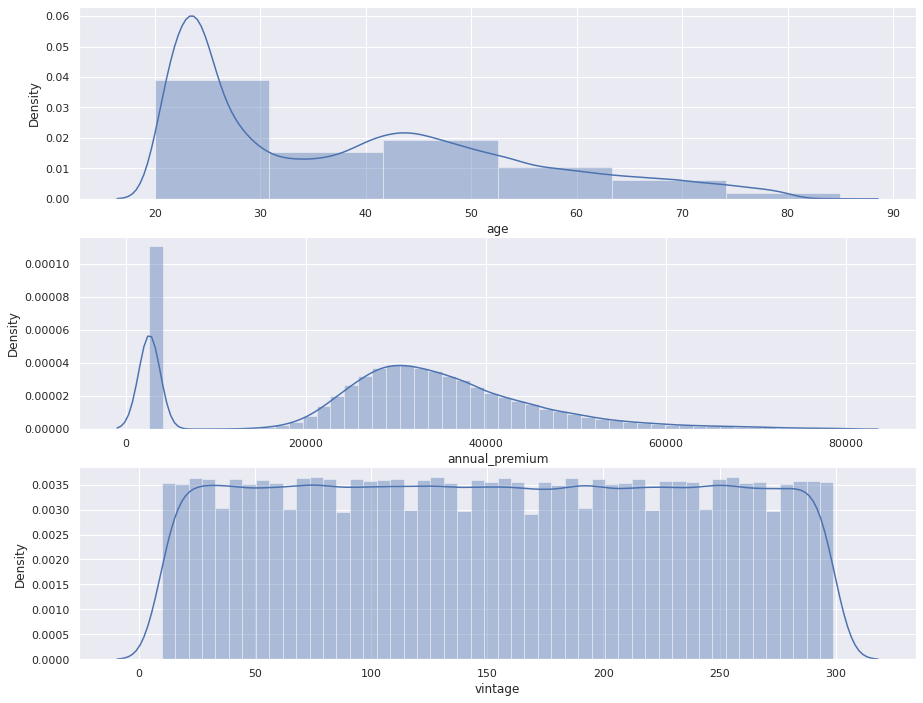

In [29]:
fig, axs = plt.subplots(3, figsize = (15,12))
sns.distplot(df1['age'], ax = axs[0], bins = 6)
sns.distplot(df1[df1['annual_premium'] < 80000]['annual_premium'], ax = axs[1])
sns.distplot(df1['vintage'], ax = axs[2]);

### 1.5.2. Categorical attributes

In [17]:
cat_attributes.apply(lambda x: x.unique().shape[0])

driving_license           2
previously_insured        2
vehicle_damage            2
vehicle_age               3
gender                    2
region_code              53
policy_sales_channel    155
dtype: int64

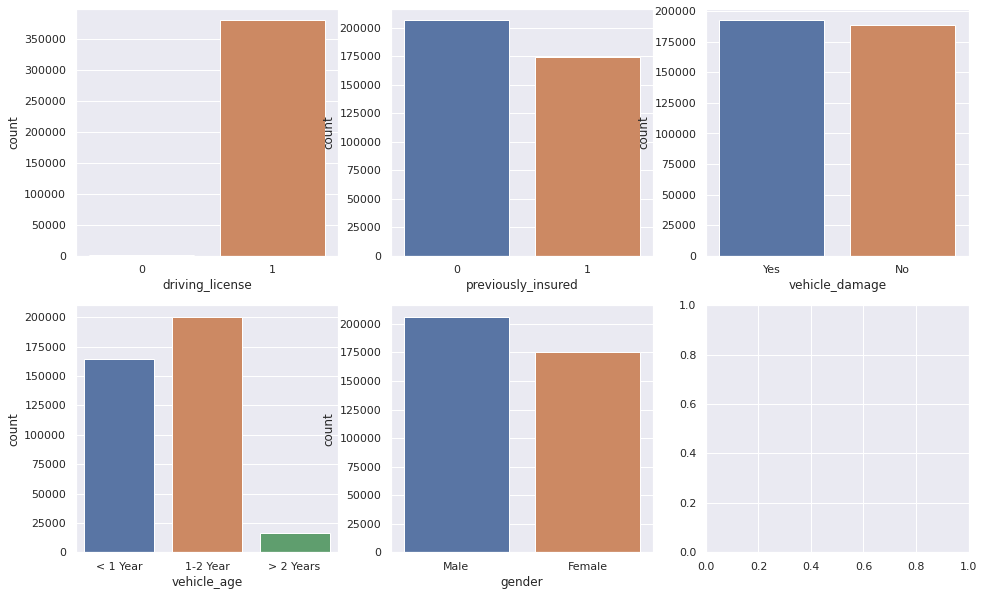

In [30]:
fig, axs = plt.subplots(ncols = 3, nrows = 2,  figsize = (16,10), )
sns.countplot(x = 'driving_license', data = df1, ax = axs[0][0])
sns.countplot(x = 'previously_insured', data = df1, ax = axs[0][1])
sns.countplot(x = 'vehicle_damage', data = df1, ax = axs[0][2])
sns.countplot(x = 'vehicle_age', data = df1, ax = axs[1][0])
sns.countplot(x = 'gender', data = df1, ax = axs[1][1]);

In [31]:
driving_license_perc = (df1['driving_license'].sum()) / (df1.shape[0])
driving_license_perc = "{0:.2f}%".format(driving_license_perc * 100)
print ('The percentage of YES for Driving License is {}'.format(driving_license_perc))

previously_insured_perc = (df1['previously_insured'].sum()) / (df1.shape[0])
driving_license_perc = "{0:.2f}%".format(previously_insured_perc * 100)
print ('The percentage of YES for Previously Insured is {}'.format(driving_license_perc))

vehicle_damage_perc = df1['vehicle_damage'][df1['vehicle_damage'] == 'Yes'].value_counts() / (df1.shape[0])
vehicle_damage_perc = "{0:.2f}%".format(vehicle_damage_perc[0]*100)
print ('The percentage of YES for Vehicle Damage is {}'.format(vehicle_damage_perc))

vehicle_age_perc = df1['vehicle_age'].value_counts() / (df1.shape[0])
print ('The percentage of cars with less than 1 year old is ' "{0:.2f}%".format(vehicle_age_perc[0]*100))
print ('The percentage of cars with age between 1 and 2 years is ' "{0:.2f}%".format(vehicle_age_perc[1]*100))
print ('The percentage of cars with age higher 2 years old is ' "{0:.2f}%".format(vehicle_age_perc[2]*100))

gender_perc = df1['gender'].value_counts() / (df1.shape[0])
print ('The percentage of males is ' "{0:.2f}%".format(gender_perc[0]*100))
print ('The percentage of females is ' "{0:.2f}%".format(gender_perc[1]*100))

The percentage of YES for Driving License is 99.79%
The percentage of YES for Previously Insured is 45.82%
The percentage of YES for Vehicle Damage is 50.49%
The percentage of cars with less than 1 year old is 52.56%
The percentage of cars with age between 1 and 2 years is 43.24%
The percentage of cars with age higher 2 years old is 4.20%
The percentage of males is 54.08%
The percentage of females is 45.92%


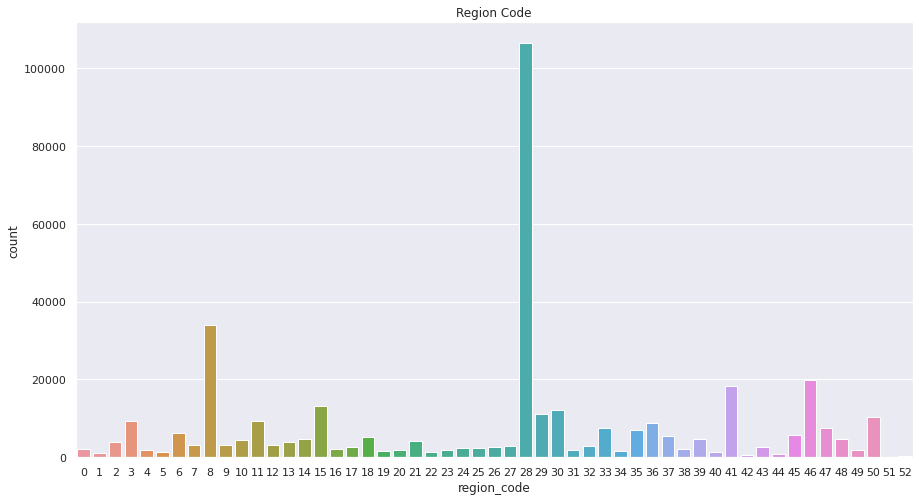

In [32]:
fig = plt.subplots(figsize = (15,8))
sns.countplot(x = 'region_code', data = df1).set_title('Region Code');

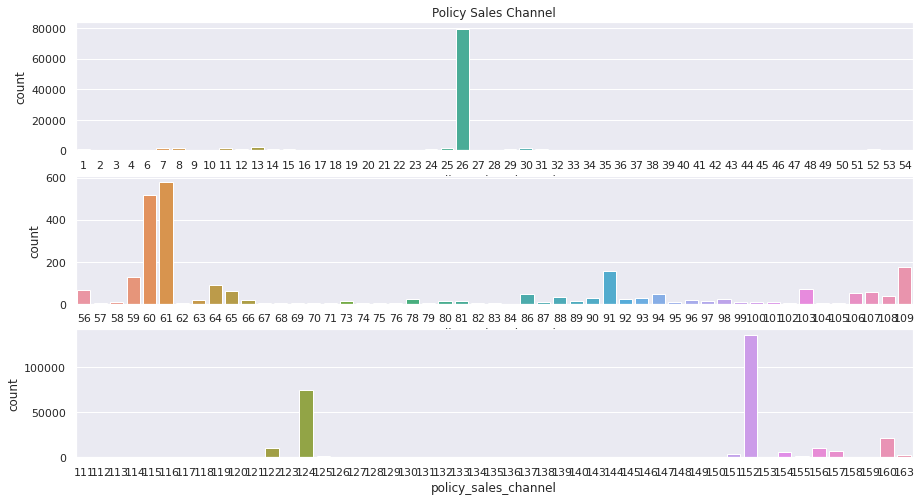

In [33]:
df_policy_1 = df1[(df1['policy_sales_channel'] > 0) & (df1['policy_sales_channel'] < 55)]
df_policy_2 = df1[(df1['policy_sales_channel'] > 55) & (df1['policy_sales_channel'] < 110)]
df_policy_3 = df1[df1['policy_sales_channel'] > 110]

fig, axs = plt.subplots(nrows = 3,  figsize = (15,8))
sns.countplot(x = 'policy_sales_channel', data = df_policy_1, ax = axs[0]).set_title('Policy Sales Channel')
sns.countplot(x = 'policy_sales_channel', data = df_policy_2, ax = axs[1])
sns.countplot(x = 'policy_sales_channel', data = df_policy_3, ax = axs[2]);

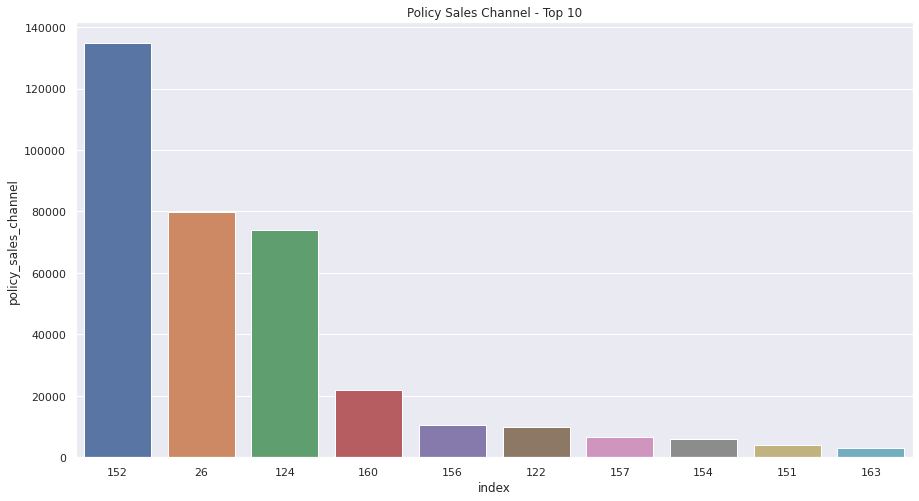

In [34]:
df_policy_reset = df1['policy_sales_channel'].value_counts().reset_index().sort_values('policy_sales_channel', ascending = False)
df_policy_reset_filter = df_policy_reset[df_policy_reset['policy_sales_channel'] > 2000]

fig = plt.subplots(figsize = (15,8))
sns.barplot(y = 'policy_sales_channel', x = 'index', data = df_policy_reset_filter, order = df_policy_reset_filter['index']).set_title('Policy Sales Channel - Top 10');

In [20]:
most_used_channels_perc = (df_policy_reset_filter['policy_sales_channel'].sum()) / (df1.shape[0])
most_used_channels_perc = "{0:.2f}%".format(most_used_channels_perc * 100)
print ('The 10 most used channels represent {} of all data.'.format(most_used_channels_perc))

The 10 most used channels represent 91.92% of all data.


### 1.5.3. Target attribute

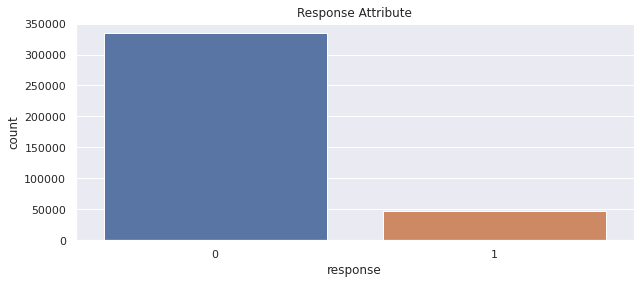

In [35]:
fig = plt.subplots(figsize = (10,4))
sns.countplot(x = 'response', data = df1).set_title('Response Attribute');

In [36]:
response_perc = df1['response'].value_counts() / (df1.shape[0])
print ('The percentage of NO is ' "{0:.2f}%".format(response_perc[0]*100))
print ('The percentage of YES is ' "{0:.2f}%".format(response_perc[1]*100))

The percentage of NO is 87.74%
The percentage of YES is 12.26%


### 1.5.4. Data Description Summary

<h3>Data Description Summary for numerical attributes:</h3>
<ol>
    <li>
        <strong>Age</strong>
            <ul>
                <li>Range: 20 to 85 years old;</li>
                <li>Mean: 38.52 years old;</li>
                <li>Median: 36 years old;</li>
                <li>Density: Higher density is from 20 to 29 about 41%, followed by 40 to 49 with 20%.</li>
            </ul>
    </li>
    <br>
    <li>
        <strong>Annual_premium</strong>
            <ul>
                <li>Range: 2630 to 540165;</li>
                <li>There is a peak in 2630, and a high density around 20000 to 60000.</li>
            </ul>
    </li>
    <br>
    <li>
        <strong>Vintage</strong>
            <ul>
                <li>Range: 10 to 299 days;</li>
                <li>Mean: 154.347397 days;</li>
                <li>Median: 154 days.</li>
            </ul>
     </li>
</ol>

<h3>Data description summary for categorical attributes:</h3>
<ol>
    <li>
        <strong>Driving License</strong>
            <ul>
                <li>There are 2 options: 0 for No and 1 for Yes</li>
                <li>The percentage of YES for Driving License is 99.79%</li>               
            </ul>
    </li>
    <br>
    <li>
        <strong>Previously Insured</strong>
            <ul>
                <li>There are 2 options: 0 for No and 1 for Yes</li>
                <li>The percentage of YES for Previously Insured is 45.82%</li>
            </ul>
    </li>
    <br>
    <li>
        <strong>Vehicle Damage</strong>
            <ul>
                <li>There are 2 options: Yes ou No</li>
                <li>The percentage of YES for Vehicle Damage is 50.49%</li>                
            </ul>
    </li>
    <br>
    <li>
        <strong>Vehicle Age</strong>
            <ul>
                <li>There are 3 options: Less than 1 year old, between 1 and 2 years old e higher than 2 years old</li>
                <li>The distribution between this options is:</li>
                    <ul>
                        <li>Cars with less than 1 year old is 52.56%</li>
                        <li>Cars with age between 1 and 2 years is 43.24%</li>
                        <li>Cars with age higher 2 years old is 4.20%</li>
                    </ul>
            </ul>
    </li>
    <br>
    <li>
        <strong>Gender</strong>
            <ul>
                <li>There are 2 options: Male or Female</li>
                <li>The distribution between this options is:</li>
                    <ul>
                        <li>Males >>> 54.08%</li>
                        <li>Females >>> 45.92%</li>                        
                    </ul>                
            </ul>
    </li>
    <br>
    <li>
        <strong>Region Code</strong>
            <ul>
                <li>The feature contain 53 differents regions</li>
           </ul>    
    </li>
    <br>
    <li>
        <strong>Policy Sales Channel</strong>
            <ul>
                <li>The feature contain 155 differents channels</li>
                <li>The 10 most used channels are responsible for 91.92% of all contacts</li>
           </ul>    
    </li>
</ol>

<h3>Data description for response variable:</h3>
<ul>
    <li>There are a great difference between the percentages of YES and NO</li>
       <ul>
            <li> YES >>> 87.74%</li>
            <li> NO >>> 12.26%</li>
       </ul>
    <br>
    <li><strong>This situation will be evaluated during the development of the solution.</strong></li> 
</ul>

# 2.0. Feature Engineering

## 2.1 Hypotheses Mind Map

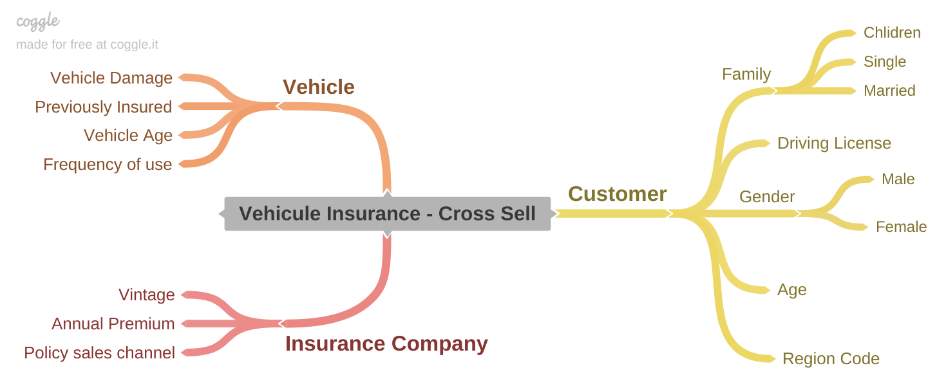

In [3]:
Image('../img/mind_map_cross_sell.png')

## 2.2 Creating Hypotheses

### 2.2.1 Customer Hypotheses
**1.** Women are more likely to take out car insurance.<br>
**2.** The older the age, the greater the possibility of taking out car insurance.<br>
**3.** The place of residence influences the decision to take out car insurance.<br>
**4.** Married people are more likely to take out car insurance.<br>
**5.** People with children are more likely to buy car insurance.<br>

### 2.2.2 Vehicle Hypotheses
**1.** People who have had damage to their cars are more likely to take out car insurance.<br>
**2.** People who already have car insurance are more likely to purchase a new policy.<br>
**3.** People with newer vehicles are more likely to take out car insurance.<br>
**4.** People who use their car more frequently are more likely to take out car insurance.<br>

### 2.2.3 Insurance Company Hypotheses
**1.** Clients with an older relationship with the insurance company are more likely to contract a new product.<br>
**2.** Customers with higher health insurance expenses are more likely to purchase a new product.<br>

## 2.3 Hypotheses Final List


**1.** Women are more likely to take out car insurance.<br>
**2.** The older the age, the greater the possibility of taking out car insurance.<br>
**3.** The place of residence influences the decision to take out car insurance.<br>
**4.** People who have had damage to their cars are more likely to take out car insurance.<br>
**5.** People who already have car insurance are more likely to purchase a new policy.<br>
**6.** People with newer vehicles are more likely to take out car insurance.<br>
**7.** Clients with an older relationship with the insurance company are more likely to contract a new product.<br>
**8.** Customers with higher health insurance expenses are more likely to purchase a new product.<br>

## 2.4 Feature Engineering

In [13]:
df2 = df1.copy()

In [14]:
# Vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 3 if x == '> 2 Years' else 2 if x == '1-2 Year' else 1)
df2['region_code'] = df2['region_code'].astype(np.int64)

# Vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0)

# Gender
df2['gender'] = df2['gender'].apply( lambda x: 1 if x == 'Female' else 0)

In [15]:
# Creating Damage por region code index
damage_per_rcode = df2[['vehicle_damage']].groupby(df2['region_code']).mean().reset_index()
damage_per_rcode = damage_per_rcode.rename( columns = {'vehicle_damage' : 'damage_per_rcode'})
df2 = df2.merge(damage_per_rcode, on = 'region_code', how = 'left')
df2['damage_per_rcode'] = df2['damage_per_rcode'].astype(np.float64)

# 3.0. Data Filtering

In [16]:
# At moment, there are no filter to apply.
df3 = df2.copy()

# 4.0. EDA

In [17]:
df4 = df3.copy()

In [18]:
df4.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'previously_insured', 'annual_premium', 'vintage', 'driving_license',
       'vehicle_age', 'vehicle_damage', 'response', 'damage_per_rcode'],
      dtype='object')

## 4.1.Univariate Analysis

### 4.1.1 Response Variable

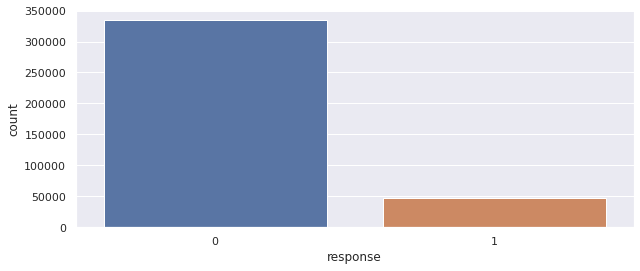

In [44]:
fig = plt.subplots(figsize = (10,4))
sns.countplot('response', data = df4);

### 4.1.2 Numerical Attributes

#### Age

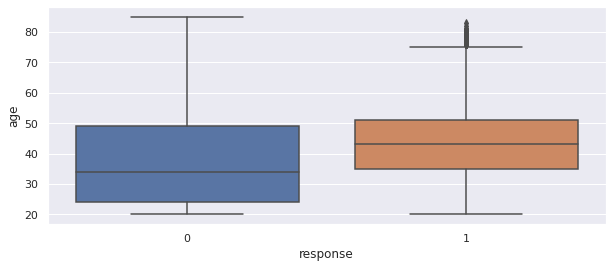

In [33]:
fig = plt.subplots(figsize = (10,4))
sns.boxplot(x = 'response', y = 'age', data = df4);

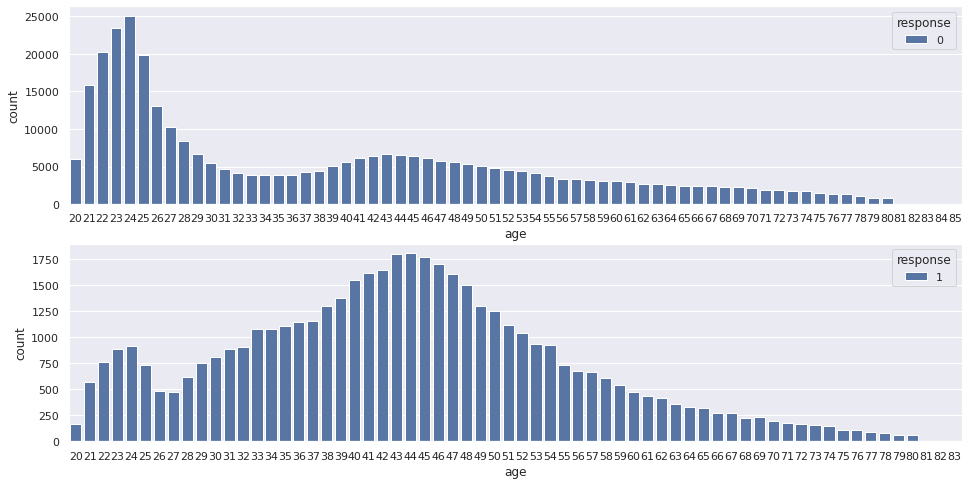

In [34]:
fig, axs = plt.subplots(nrows = 2, figsize = (16,8))
sns.countplot(x = 'age', data = df4[df4['response'] == 0], hue = 'response', ax = axs[0]);
sns.countplot(x = 'age', data = df4[df4['response'] == 1], hue = 'response', ax = axs[1]);

#### Annual premium


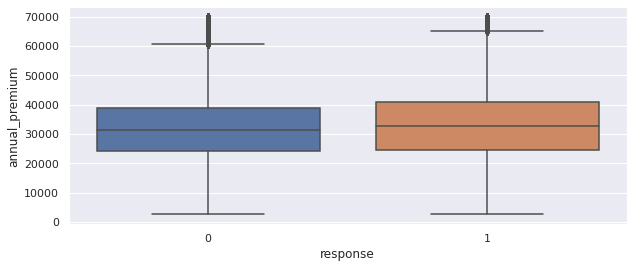

In [35]:
aux01 = df4[df4['annual_premium'] < 70000]
fig = plt.subplots(figsize = (10,4))
sns.boxplot ( x = 'response', y = 'annual_premium', data = aux01);

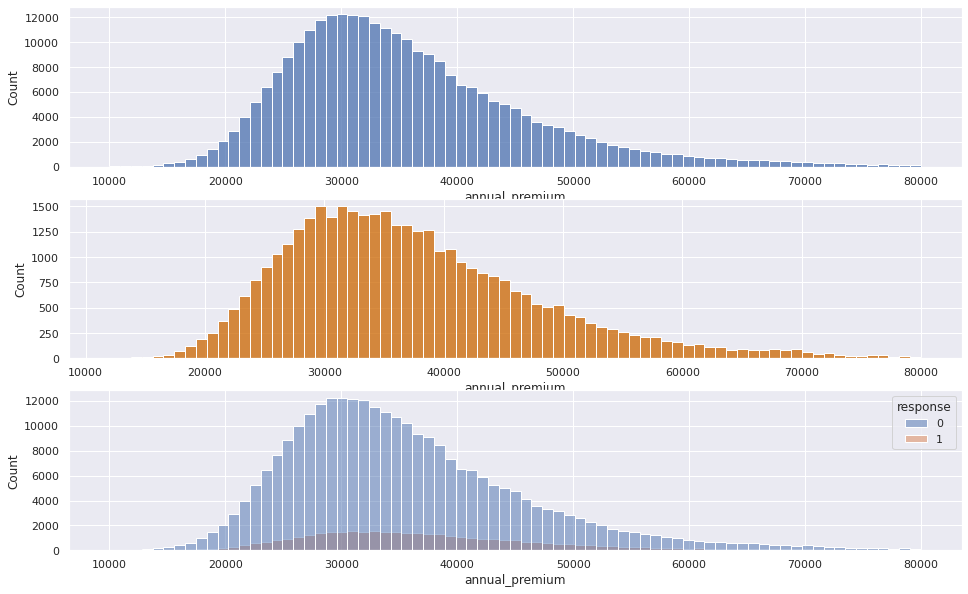

In [36]:
aux01 = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux02 = aux01.loc[aux01['response'] == 0, 'annual_premium']

aux03 = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux04 = aux03.loc[aux01['response'] == 1, 'annual_premium']

fig, axs = plt.subplots(nrows = 3, figsize = (16,10))

sns.histplot(aux02, bins = 75, ax = axs[0])
sns.histplot(aux04, bins = 75, ax = axs[1], color = o_orange)
sns.histplot(aux01, x = 'annual_premium', hue = 'response', bins = 75, ax = axs[2]);

#### Vintage

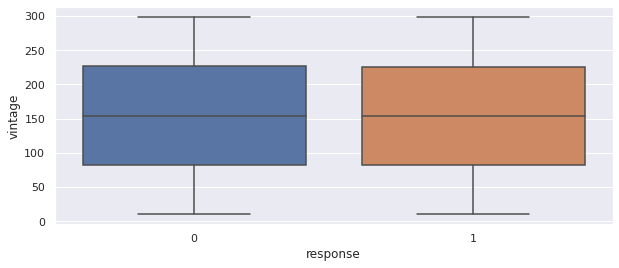

In [37]:
fig = plt.subplots(figsize = (10,4))
sns.boxplot ( x = 'response', y = 'vintage', data = df4);

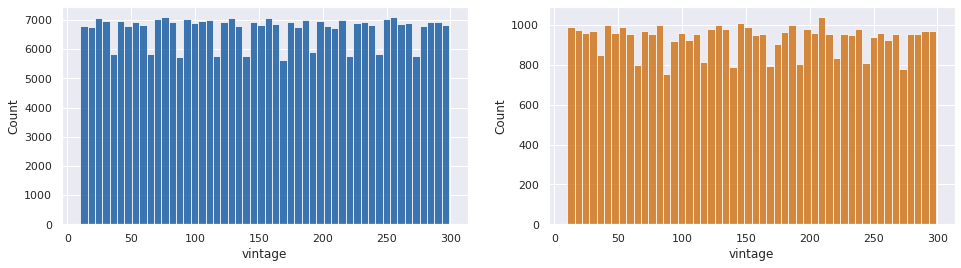

In [38]:
aux00 = df4.loc[df4['response'] == 0, 'vintage']
aux01 = df4.loc[df4['response'] == 1, 'vintage']

fig, axs = plt.subplots(ncols = 2, figsize = (16,4))

sns.histplot(aux00, bins = 50, ax = axs[0], color = b_blue);
sns.histplot(aux01, bins = 50, ax = axs[1], color = o_orange);

### 4.1.2 Categorical Attributes

#### Driving License

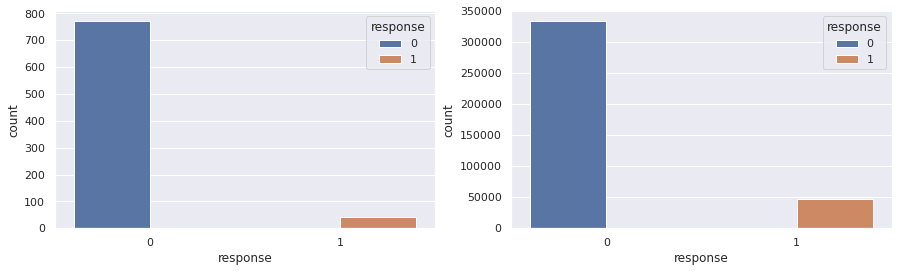

In [39]:
fig, axs = plt.subplots(ncols = 2, figsize = (15,4))
sns.countplot(x = 'response', data = df4[df4['driving_license'] == 0], hue = 'response', ax = axs[0]);
sns.countplot(x = 'response', data = df4[df4['driving_license'] == 1], hue = 'response', ax = axs[1]);

In [40]:
pd.crosstab(df4['driving_license'], df4['response'])

response,0,1
driving_license,,
0,771,41
1,333628,46669


#### Gender

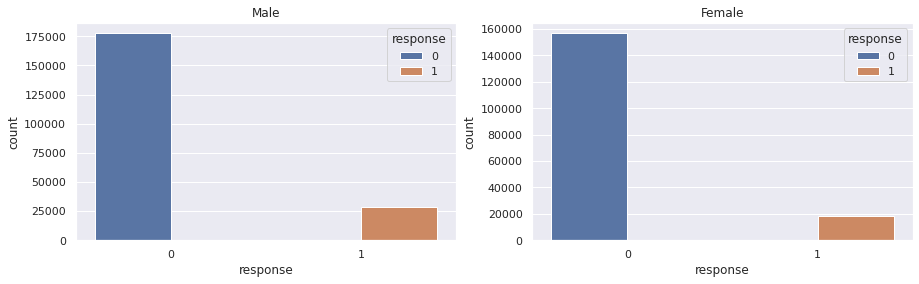

In [41]:
fig, axs = plt.subplots(ncols = 2, figsize = (15,4))
sns.countplot(x = 'response', data = df4[df4['gender'] == 0], hue = 'response', ax = axs[0]).set_title('Male');
sns.countplot(x = 'response', data = df4[df4['gender'] == 1], hue = 'response', ax = axs[1]).set_title('Female');

In [42]:
pd.crosstab(df4['gender'], df4['response'])

response,0,1
gender,,
0,177564,28525
1,156835,18185


#### Region Code

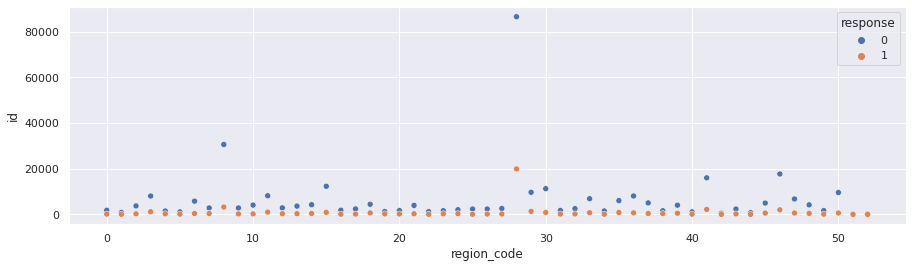

In [43]:
aux00 = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
fig = plt.subplots(figsize = (15,4))
sns.scatterplot(x = 'region_code', y = 'id', hue = 'response', data = aux00);

#### Vehicle Damage

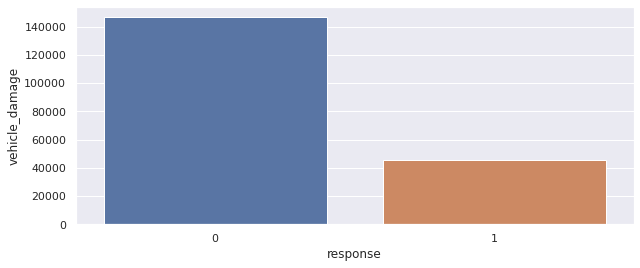

In [44]:
aux = df4[['vehicle_damage', 'response']].groupby('response').sum().reset_index()
fig = plt.subplots(figsize = (10,4))
sns.barplot(x = 'response', y = 'vehicle_damage', data = aux);

#### Damage per Region Code

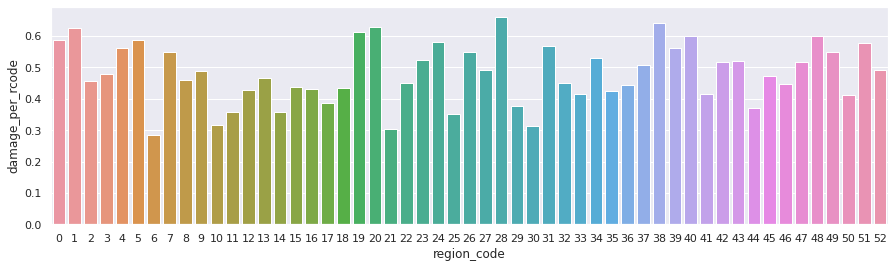

In [45]:
aux_dprc = df4[['region_code', 'damage_per_rcode']]
fig = plt.subplots(figsize = (15,4))
sns.barplot(x = 'region_code', y = 'damage_per_rcode', data = aux_dprc);

#### Previously Insured

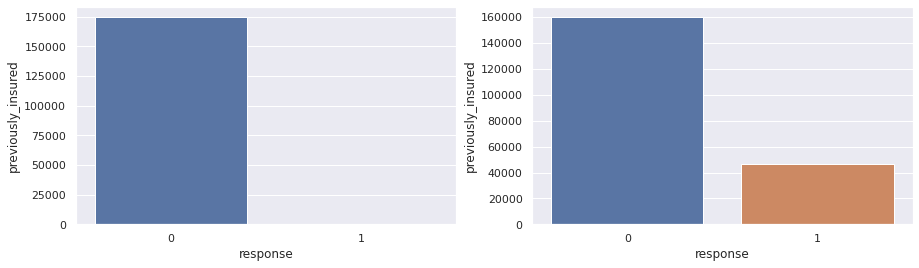

In [46]:
aux_pi_1 = df4[df4['previously_insured'] == 1].groupby('response').count().reset_index()
aux_pi_0 = df4[df4['previously_insured'] == 0].groupby('response').count().reset_index()

fig, axs = plt.subplots(ncols = 2, figsize = (15,4))
sns.barplot(x = 'response', y = 'previously_insured', data = aux_pi_1, ax = axs[0])
sns.barplot(x = 'response', y = 'previously_insured', data = aux_pi_0, ax = axs[1]);

In [47]:
pd.crosstab(df4['response'], df4['previously_insured'])

previously_insured,0,1
response,,
0,159929,174470
1,46552,158


In [48]:
pd.crosstab(df4['response'], df4['previously_insured']).apply( lambda x: (x / x.sum() * 100), axis = 1)

previously_insured,0,1
response,,
0,47.825801,52.174199
1,99.661743,0.338257


#### Vehicle Age

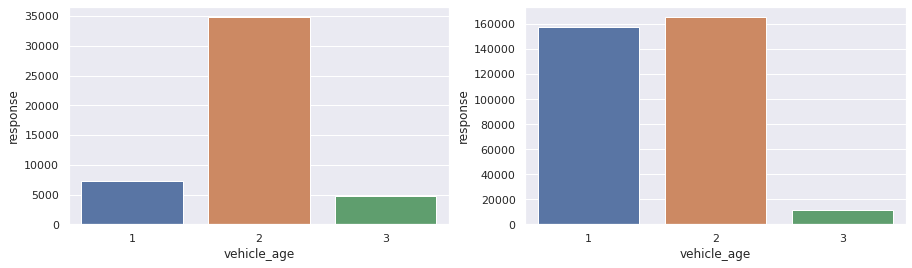

In [49]:
aux_va_1 = df4[df4['response'] == 1].groupby('vehicle_age').count().reset_index()
aux_va_0 = df4[df4['response'] == 0].groupby('vehicle_age').count().reset_index()

fig, axs = plt.subplots(ncols = 2, figsize = (15,4))
sns.barplot(x = 'vehicle_age', y = 'response', data = aux_va_1, ax = axs[0])
sns.barplot(x = 'vehicle_age', y = 'response', data = aux_va_0, ax = axs[1]);

#### Policy Sales Channel

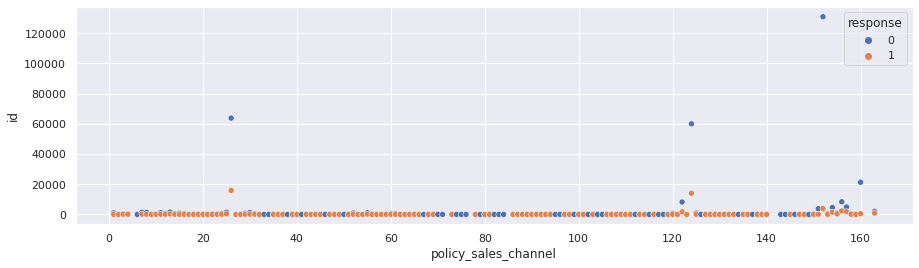

In [50]:
fig, axs = plt.subplots(figsize = (15,4))
aux_psc = df4[['id', 'policy_sales_channel', 'response']].groupby(['policy_sales_channel', 'response']).count().reset_index()
sns.scatterplot(x = 'policy_sales_channel', y ='id', hue = 'response', data = aux_psc);

## 4.2. Bivariate Analysis

### 4.2.1 Hypotheses Validation

### Women are more likely to take out car insurance.

#### The hypothesis is FALSE, the interest among men is percentage higher.

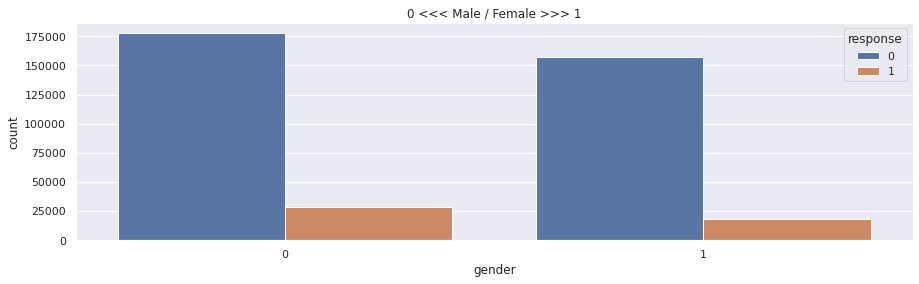

In [51]:
fig, axs = plt.subplots(figsize = (15,4))
sns.countplot(x = df4['gender'], hue = df4['response']).set_title('0 <<< Male / Female >>> 1');

In [52]:
woman = df4[df4['gender'] == 1].count()
woman_yes = df4[(df4['gender'] == 1) & (df4['response'] == 1)].count()
male = df4[df4['gender'] == 0].count()
male_yes = df4[(df4['gender'] == 0) & (df4['response'] == 1)].count()
woman_yes_perc = (woman_yes['id'] / woman['id']) * 100
male_yes_perc = (male_yes['id'] / male['id']) * 100

print ('The percentage of interest among *FEMALES* who responded to the survey is ' "{0:.2f}%".format(woman_yes_perc))
print ('The percentage of interest among *MALES* who responded to the survey is ' "{0:.2f}%".format(male_yes_perc))

The percentage of interest among *FEMALES* who responded to the survey is 10.39%
The percentage of interest among *MALES* who responded to the survey is 13.84%


### The older the age, the greater the possibility of taking out car insurance.

#### The hypothesis is FALSE.  There is a limit of age to an interest in a new policy.


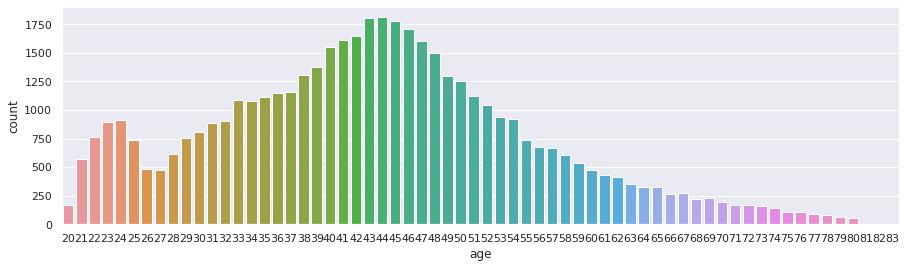

In [53]:
fig = plt.subplots(figsize = (15,4))
sns.countplot(x = 'age', data = df4[df4['response'] == 1]);

### The place of residence influences the decision to take out car insurance.

#### The hypothesis is TRUE. Some regions have a more concentration of car insurance interest.

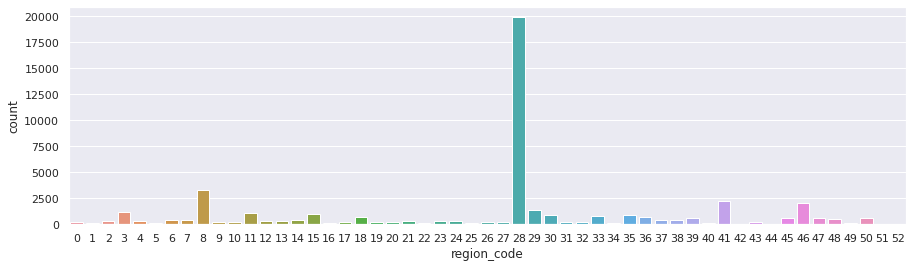

In [54]:
fig = plt.subplots(figsize = (15,4))
sns.countplot(x = 'region_code', data = df4[df4['response'] == 1]);

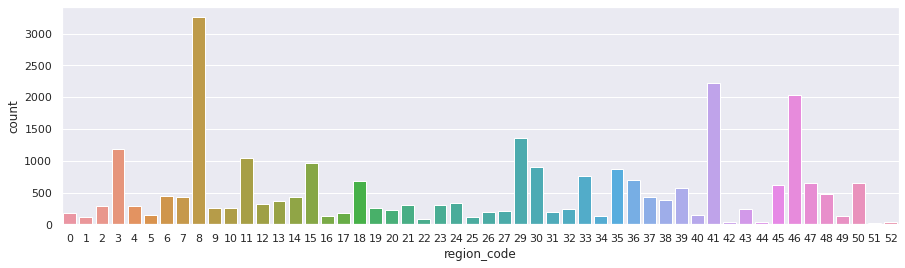

In [55]:
aux = df4[(df4['region_code'] != 28) & (df4['response'] == 1)]
fig = plt.subplots(figsize = (15,4))
sns.countplot(x = 'region_code', data = aux);

### People who have had damage to their cars are more likely to take out car insurance.

#### The hypothesis is TRUE. When happened car damage, there is car insurance interest.


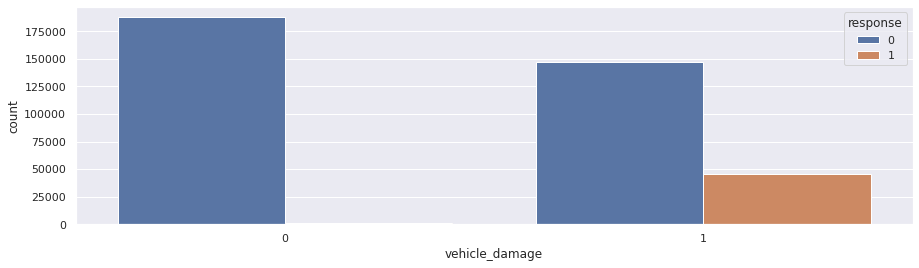

In [56]:
fig, axs = plt.subplots(figsize = (15,4))
sns.countplot(x = df4['vehicle_damage'], hue = df4['response']);

### People who already have car insurance are more likely to purchase a new policy.

#### The hypothesis is FALSE. The consumers that already have car insurance don't have an interest in a new policy.


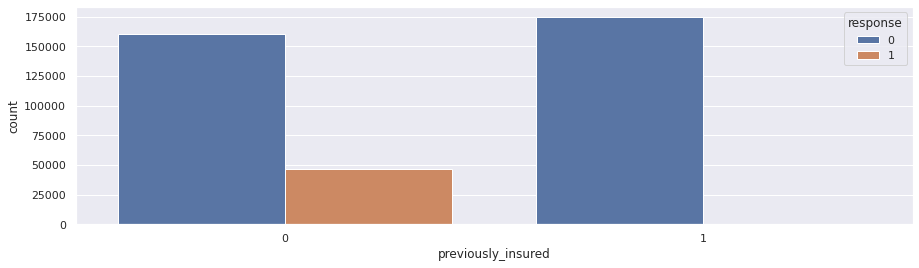

In [57]:
fig, axs = plt.subplots(figsize = (15,4))
sns.countplot(x = df4['previously_insured'], hue = df4['response']);

### People with newer vehicles are more likely to take out car insurance.

#### The hypothesis is FALSE. The interest in car insurance is concentrate between owners of vehicles with 1 and 2 years old.

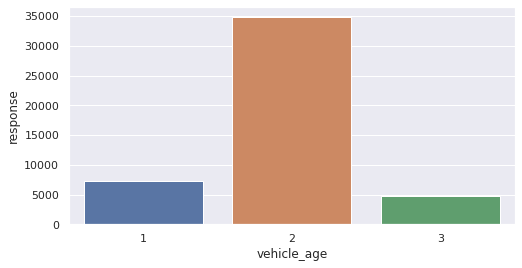

In [58]:
aux_va_1 = df4[df4['response'] == 1].groupby('vehicle_age').count().reset_index()
fig = plt.subplots(figsize = (8,4))
sns.barplot(x = 'vehicle_age', y = 'response', data = aux_va_1);

### Customers with a longer relationship with the insurance company are more likely to take out a new product.

#### The hypothesis is FALSE. There is no relationship between when the customer bought their health insurance and interest in car insurance.

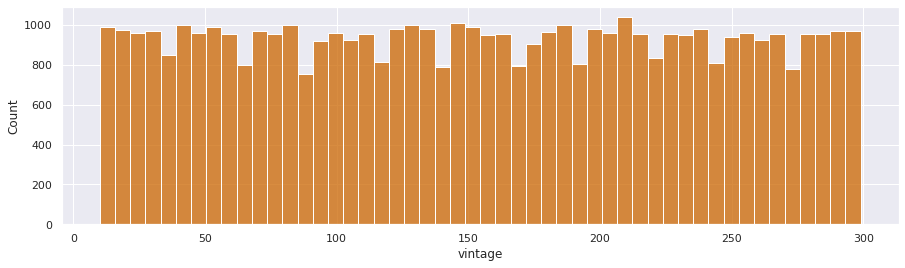

In [60]:
fig = plt.subplots(figsize = (15,4))
sns.histplot(x = 'vintage', bins = 50, data = df4[df4['response'] == 1], color = o_orange);

### Customers with higher health insurance expenses are more likely to purchase a new product.

#### The hypothesis is FALSE. There is a concentration of positive answers around of mean of annual premiums paid.


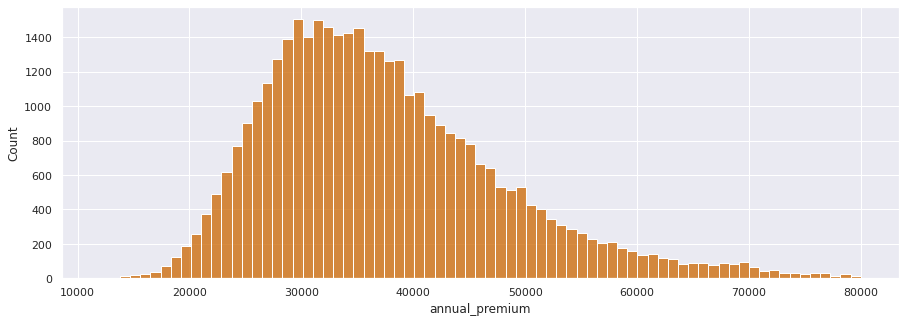

In [61]:
# annual_premium
aux_ap = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux_ap_01 = aux_ap.loc[aux_ap['response'] == 1, 'annual_premium']

fig = plt.subplots(figsize = (15,5))
sns.histplot(aux04, bins = 75, color = o_orange);

## 4.3. Multivariate Analysis

In [62]:
df4.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'previously_insured', 'annual_premium', 'vintage', 'driving_license',
       'vehicle_age', 'vehicle_damage', 'response', 'damage_per_rcode'],
      dtype='object')

In [63]:
df4.dtypes

id                        int64
gender                    int64
age                       int64
region_code               int64
policy_sales_channel      int64
previously_insured        int64
annual_premium          float64
vintage                   int64
driving_license           int64
vehicle_age               int64
vehicle_damage            int64
response                  int64
damage_per_rcode        float64
dtype: object

In [19]:
# Numerical attributes
num_attributes = df4[['age', 'annual_premium', 'vintage']]

# Categorical attibutes
cat_attributes = df4[['gender', 'region_code', 'policy_sales_channel', 'previously_insured', 'driving_license', 'vehicle_age', 'vehicle_damage', 'damage_per_rcode', 'response']]

# Target
target_atribute = df4['response']

### 4.3.1 Numerical Attributes

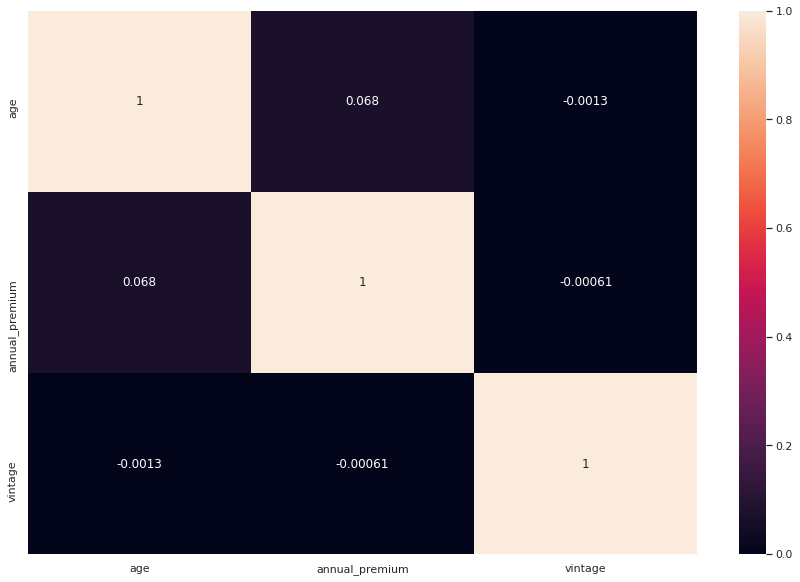

In [46]:
correlation = num_attributes.corr(method = 'pearson')
fig = plt.subplots(figsize = (15,10))
sns.heatmap(correlation, annot = True);

### 4.3.1 Categorical Attributes

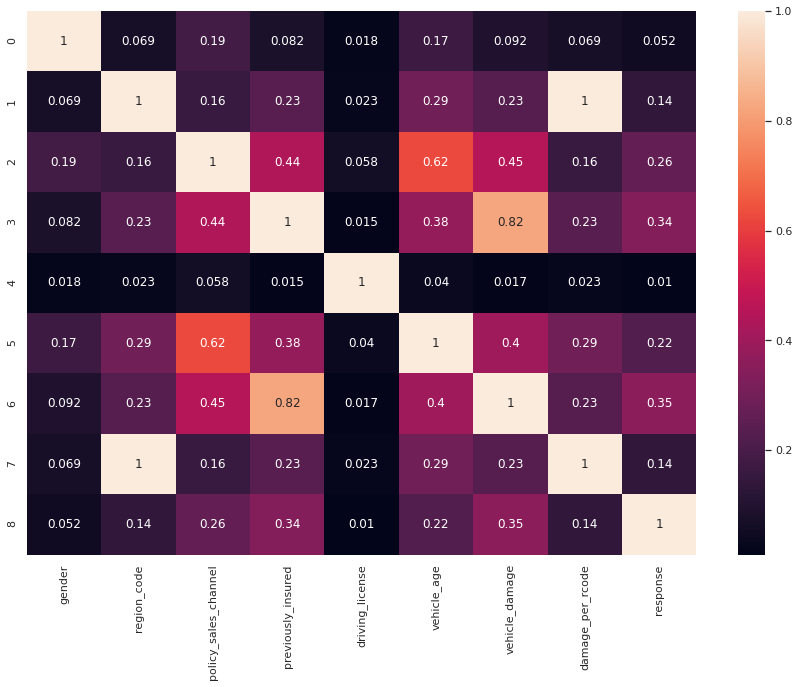

In [47]:
fig = plt.subplots(figsize = (15,10))
sns.heatmap(pd.DataFrame(corr_cramer_v(cat_attributes)), annot = True);

In [21]:
cols_selected_eda = ['vehicle_damage', 'policy_sales_channel', 'vehicle_age', 'previously_insured', 'response']

# 5.0. Data Preparation

## Split dataset

In [20]:
df5 = df4.copy()

In [22]:
X = df4.drop('response', axis = 1)
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split (X, y, test_size = 0.20)

df5 = pd.concat ([x_train, y_train], axis = 1)

In [23]:
print ('Number of Rows: {}'.format(df5.shape[0]))
print ('Number of Columns: {}'.format(df5.shape[1]))

Number of Rows: 304887
Number of Columns: 13


In [71]:
df5.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'previously_insured', 'annual_premium', 'vintage', 'driving_license',
       'vehicle_age', 'vehicle_damage', 'damage_per_rcode', 'response'],
      dtype='object')

## Standardization

In [24]:
ss = pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
pickle.dump(ss, open('../src/features/annual_premium_scaler.pkl', 'wb'))

## Rescaling

In [25]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump(mms_age, open('../src/features/age_scaler.pkl', 'wb' ) )

# vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
pickle.dump(mms_vintage, open('../src/features/vintage_scaler.pkl', 'wb'))

## Encoder

In [26]:
# gender - Target Enconding
target_encode_gender = df5.groupby ('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map(target_encode_gender)
pickle.dump(target_encode_gender, open('../src/features/gender_scaler.pkl', 'wb'))

# region_code - Target Enconding
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region_code)
pickle.dump(target_encode_region_code, open('../src/features/region_code_scaler.pkl', 'wb'))

# policy_sales_channel - Target Enconding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)
pickle.dump(fe_policy_sales_channel, open('../src/features/policy_sales_scaler.pkl', 'wb'))

# Vehicle Age - Target Enconding
target_encode_vehicle_age = df5.groupby ('vehicle_age')['response'].mean()
df5.loc[:, 'vehicle_age'] = df5['vehicle_age'].map(target_encode_vehicle_age)
pickle.dump(target_encode_gender, open('../src/features/vehicle_age_scaler.pkl', 'wb'))

## 5.4. Validation Data Preparation

In [27]:
# gender - One hot enconding / Target Enconding
x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map(target_encode_gender)

# Vehicle Age
x_validation.loc[:, 'vehicle_age'] = x_validation.loc[:, 'vehicle_age'].map(target_encode_vehicle_age)

# age
x_validation.loc[:, 'age'] = mms_age.fit_transform(x_validation[['age']].values)

# region_code - Frequency Enconding / Target Enconding / Weighted Target Enconding
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map(target_encode_region_code)

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.fit_transform(x_validation[['annual_premium']].values)

# policy_sales_channel - Target Enconding / Frequency Enconding
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.fit_transform(x_validation[['vintage']].values)

# fillna
x_validation = x_validation.fillna (0)

# 6.0. Features Selection

In [28]:
df6 = df5.copy()

## 6.1 Boruta

In [29]:
x_train_b = df6.drop(['id', 'response'], axis = 1).values
y_train_b = y_train.values.ravel()

rf = RandomForestClassifier(n_jobs = -1)
boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 0, random_state = 77).fit(x_train_b,y_train_b)

In [30]:
# Comentado para não fazer o algoritimo do boruta #
cols_selected = boruta.support_.tolist()

#colunas selecionadas
x_train_fs = df6.drop(['id', 'response'], axis = 1)
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

#colunas não selecionadas
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns,cols_selected_boruta))
print("BorutaSelected Column:")
cols_selected_boruta

BorutaSelected Column:


['age']

## 6.2 Features Importance

In [77]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators = 250, random_state = 0, n_jobs = 1)

# data preparation
x_train_n = df6.drop(['id', 'response'], axis = 1)
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=1, random_state=0)

In [78]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip (x_train_n, forest.feature_importances_):
    aux = pd.DataFrame( {'feature' : i, 'importance' : j}, index=[0])
    df = pd.concat ( [df, aux], axis = 0 )
    
print ( df.sort_values ('importance', ascending = False) )

Feature ranking:
                feature  importance
0               vintage    0.281169
0        annual_premium    0.248956
0                   age    0.173648
0        vehicle_damage    0.075535
0  policy_sales_channel    0.064884
0    previously_insured    0.052114
0           region_code    0.041247
0      damage_per_rcode    0.038319
0           vehicle_age    0.016724
0                gender    0.006877
0       driving_license    0.000528


<h3>Selected Columns:</h3>

<ul><strong>From EDA</strong>
    <ul>
        <li>'vehicle_damage'</li>
        <li>'policy_sales_channel'</li>
        <li>'vehicle_age'</li>
        <li>'previously_insured'</li>
        <li>'response'</li>
    </ul>
</ul>
                      
<ul><strong>From Boruta</strong>
    <ul>
        <li>'age'</li>
    </ul>
</ul>

<ul><strong>From Features Importance</strong>
    <ul>
        <li>'vintage'</li>
        <li>'annual_premium'</li>
        <li>'age'</li>
        <li>'vehicle_damage'</li>
        <li>'policy_sales_channel'</li>
        <li>'previously_insured'</li>
        <li>'region_code'</li>
        <li>'damage_per_rcode'</li>
    </ul>
</ul>

<h3>Features final list:</h3>
    <ol>
        <li>'vehicle_damage'</li>
        <li>'policy_sales_channel'</li>
        <li>'vehicle_age'</li> 
        <li>'previously_insured'</li>
        <li>'vintage'</li>
        <li>'annual_premium'</li>
        <li>'age'</li>
        <li>'region_code'</li>
        <li>'damage_per_rcode'</li>
    </ol>

# 7.0. Machine Learning Models

In [31]:
df7 = df6.copy()

In [32]:
cols_selected = ['vehicle_damage', 
                 'policy_sales_channel', 
                 'vehicle_age',
                 'previously_insured',
                 'vintage',
                 'annual_premium',
                 'age',
                 'region_code',
                 'damage_per_rcode'] 

x_train = df7[cols_selected]
x_val = x_validation[cols_selected]
y_val = y_validation.copy()

## 7.1. K Neighbors Classifier Model - KNN

In [34]:
# Model definition
knn_model = nh.KNeighborsClassifier (n_neighbors = 6)

# Model training
knn_model.fit(x_train, y_train)

# Model prediction - POWER OF GENERALIZATION
yhat_knn = knn_model.predict_proba (x_val)

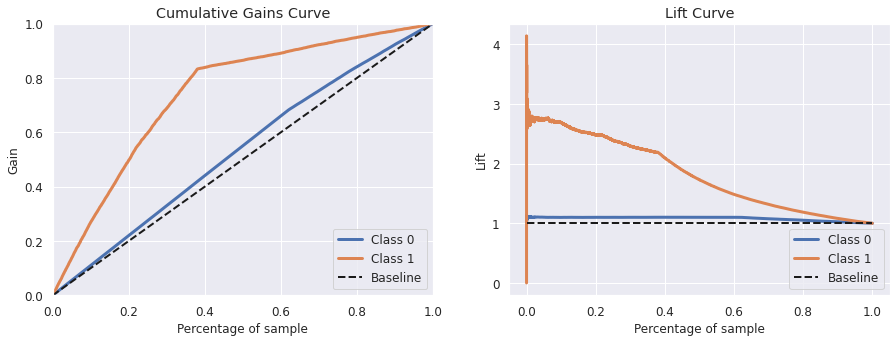

In [35]:
# Accumulative Gain
fig, axs = plt.subplots(ncols = 2, figsize = (15,5))
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn, ax = axs[0])
skplt.metrics.plot_lift_curve(y_val, yhat_knn, ax = axs[1]);

## 7.2. Logistic Regression Model

In [36]:
# Model definition
lr_model = lm.LogisticRegression(random_state = 42)

# Model training
lr_model.fit(x_train, y_train)

#Model prediction
yhat_lr = lr_model.predict_proba(x_val)

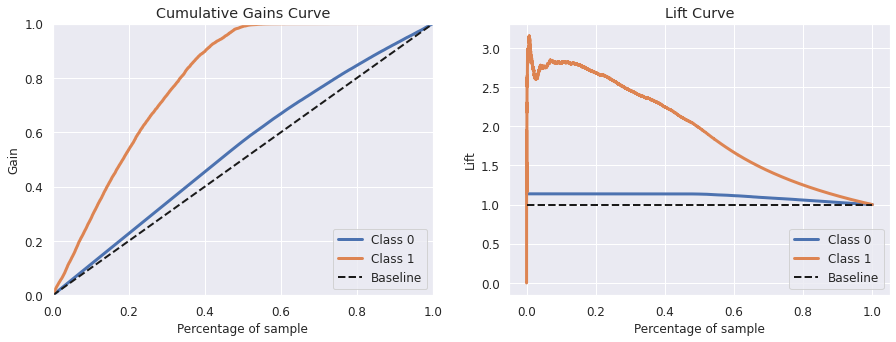

In [37]:
# Accumulative gain and Lift
fig, axs = plt.subplots(ncols = 2, figsize = (15,5))
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr, ax = axs[0])
skplt.metrics.plot_lift_curve(y_val, yhat_lr, ax = axs[1]);

## 7.3. Random Forest Classifier

In [133]:
rfc_model = RandomForestClassifier(n_estimators = 500, random_state = 42)

rfc_model.fit(x_train,y_train)

yhat_rfc = rfc_model.predict_proba(x_val)

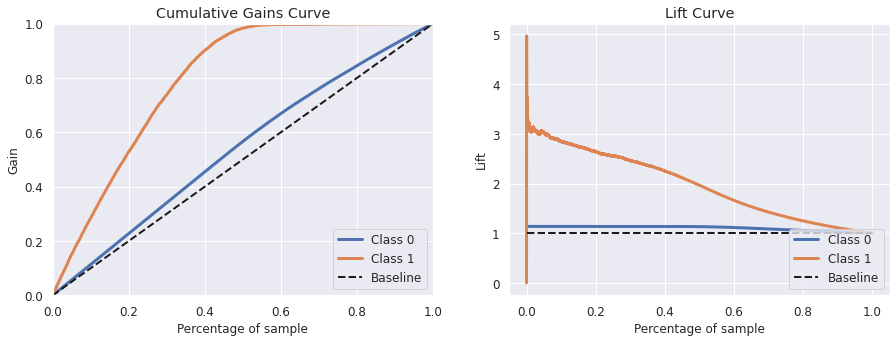

In [134]:
fig, axs = plt.subplots(ncols = 2, figsize = (15,5))
skplt.metrics.plot_cumulative_gain(y_val, yhat_rfc, ax = axs[0])
skplt.metrics.plot_lift_curve(y_val, yhat_rfc, ax = axs[1]);

## 7.4. Naive Bayes Classifier Model

In [135]:
nbc_model = GaussianNB()

nbc_model.fit(x_train,y_train)

yhat_nbc = nbc_model.predict_proba(x_val)

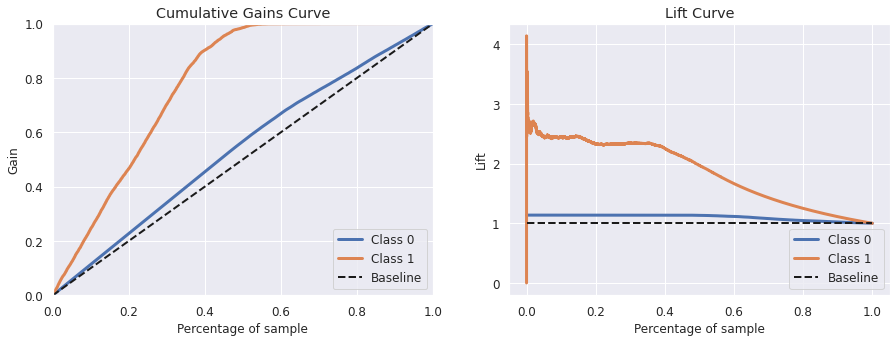

In [136]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,5))
skplt.metrics.plot_cumulative_gain(y_val, yhat_nbc, ax=axs[0])
skplt.metrics.plot_lift_curve(y_val, yhat_nbc,ax=axs[1]);

## 7.5. XGBoost Classifier

In [38]:
xgb_model = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'error')

xgb_model.fit(x_train,y_train)

yhat_xgb = xgb_model.predict_proba(x_val)

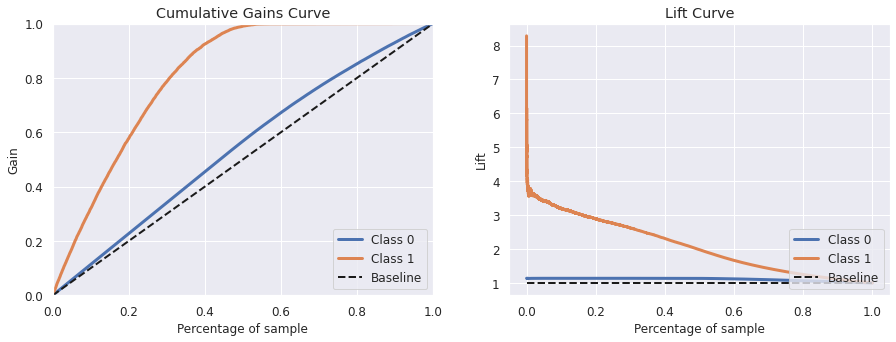

In [39]:
fig, axs = plt.subplots(ncols = 2, figsize = (15,5))
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb, ax = axs[0])
skplt.metrics.plot_lift_curve(y_val, yhat_xgb, ax = axs[1]);

# 8.0 Calculate Model's Performance

In [40]:
df8 = df7.copy()

## 8.1 Single performance

### 8.1.1 K Neighbors Classifier Model - KNN

In [144]:
# compute precision at k
knn_precision_at_k = round(precision_at_k(df8, x_validation, y_validation, yhat_knn, 25000), 3)
print('KNN Model - Precision at K: {}'.format(knn_precision_at_k))

# compute Recall at k
knn_recall_at_k = round(recall_at_k(df8, x_validation, y_validation, yhat_knn, 25000), 3)
print('KNN Model - Recall at K: {}'.format(knn_recall_at_k))

# compute f1 score at k
knn_f1_score_at_k = round(2*(knn_precision_at_k * knn_recall_at_k) / (knn_precision_at_k + knn_recall_at_k),3)
print('KNN Model - F1 Score at K: {}'.format(knn_f1_score_at_k))

# compute ROC AUC at k
knn_roc_at_k = round(m.roc_auc_score(y_validation, yhat_knn[:,1]), 3)
print('KNN Model - ROC AUC Score: {}'.format(knn_roc_at_k))

KNN Model - Precision at K: 0.269
KNN Model - Recall at K: 0.732
KNN Model - F1 Score at K: 0.393
KNN Model - ROC AUC Score: 0.774


### 8.1.2 Logistic Regression Model

In [150]:
# compute precision at k
lr_precision_at_k = round(precision_at_k(df8, x_validation, y_validation, yhat_lr, 25000), 3)
print('LREG Model - Precision at K: {}'.format(lr_precision_at_k))

# compute Recall at k
lr_recall_at_k = round(recall_at_k(df8, x_validation, y_validation, yhat_lr, 25000), 3)
print('LREG Model - Recall at K: {}'.format(lr_recall_at_k))

# compute f1 score at k
lr_f1_score_at_k = round(2*(lr_precision_at_k * lr_recall_at_k) / (lr_precision_at_k + lr_recall_at_k),3)
print('LREG Model - F1 Score at K: {}'.format(lr_f1_score_at_k))

# compute ROC AUC at k
lr_roc_at_k = round(m.roc_auc_score(y_validation, yhat_lr[:,1]), 3)
print('LREG Model - ROC AUC Score: {}'.format(lr_roc_at_k))

LREG Model - Precision at K: 0.289
LREG Model - Recall at K: 0.785
LREG Model - F1 Score at K: 0.422
LREG Model - ROC AUC Score: 0.837


### 8.1.5 XGBoost Classifier Model

In [151]:
# compute precision at k
xgb_precision_at_k = round(precision_at_k(df8, x_validation, y_validation, yhat_xgb, 25000), 3)
print('XGB Model - Precision at K: {}'.format(xgb_precision_at_k))

# compute Recall at k
xgb_recall_at_k = round(recall_at_k(df8, x_validation, y_validation, yhat_xgb, 25000), 3)
print('XGB Model - Recall at K: {}'.format(xgb_recall_at_k))

# compute f1 score at k
xgb_f1_score_at_k = round(2*(xgb_precision_at_k * xgb_recall_at_k) / (xgb_precision_at_k + xgb_recall_at_k),3)
print('XGB Model - F1 Score at K: {}'.format(xgb_f1_score_at_k))

# compute ROC AUC at k
xgb_roc_at_k = round(m.roc_auc_score(y_validation, yhat_xgb[:,1]), 3)
print('XGB Model - ROC AUC Score: {}'.format(xgb_roc_at_k))

XGB Model - Precision at K: 0.307
XGB Model - Recall at K: 0.833
XGB Model - F1 Score at K: 0.449
XGB Model - ROC AUC Score: 0.856


### 8.1.3 Random Forest Classifier

In [152]:
# compute precision at k
rfc_precision_at_k = round(precision_at_k(df8, x_validation, y_validation, yhat_rfc, 25000), 3)
print('RFC Model - Precision at K: {}'.format(rfc_precision_at_k))

# compute Recall at k
rfc_recall_at_k = round(recall_at_k(df8, x_validation, y_validation, yhat_rfc, 25000), 3)
print('RFC Model - Recall at K: {}'.format(rfc_recall_at_k))

# compute f1 score at k
rfc_f1_score_at_k = round(2*(rfc_precision_at_k * rfc_recall_at_k) / (rfc_precision_at_k + rfc_recall_at_k),3)
print('RFC Model - F1 Score at K: {}'.format(rfc_f1_score_at_k))

# compute ROC AUC at k
rfc_roc_at_k = round(m.roc_auc_score(y_validation, yhat_rfc[:,1]), 3)
print('RFC Model - ROC AUC Score: {}'.format(rfc_roc_at_k))

RFC Model - Precision at K: 0.291
RFC Model - Recall at K: 0.79
RFC Model - F1 Score at K: 0.425
RFC Model - ROC AUC Score: 0.836


### 8.1.4 Naive Bayes Classifier Model

In [153]:
# compute precision at k
nbc_precision_at_k = round(precision_at_k(df8, x_validation, y_validation, yhat_nbc, 25000), 3)
print('NBC Model - Precision at K: {}'.format(nbc_precision_at_k))

# compute Recall at k
nbc_recall_at_k = round(recall_at_k(df8, x_validation, y_validation, yhat_nbc, 25000), 3)
print('NBC Model - Recall at K: {}'.format(nbc_recall_at_k))

# compute f1 score at k
nbc_f1_score_at_k = round(2*(nbc_precision_at_k * nbc_recall_at_k) / (nbc_precision_at_k + nbc_recall_at_k),3)
print('NBC Model - F1 Score at K: {}'.format(nbc_f1_score_at_k))

# compute ROC AUC at k
nbc_roc_at_k = round(m.roc_auc_score(y_validation, yhat_nbc[:,1]), 3)
print('NBC Model - ROC AUC Score: {}'.format(nbc_roc_at_k))

NBC Model - Precision at K: 0.282
NBC Model - Recall at K: 0.767
NBC Model - F1 Score at K: 0.412
NBC Model - ROC AUC Score: 0.821


### 8.1.5 Single Performance Summary

In [154]:
m_perf_dict = {
    'Model'               : ['KNN', 'LReg', 'RForest', 'NBayes', 'XGBoost'],
    'Precision at K'      : [knn_precision_at_k, lr_precision_at_k, rfc_precision_at_k, nbc_precision_at_k, xgb_precision_at_k],
    'Recall at K'         : [knn_recall_at_k,    lr_recall_at_k,    rfc_recall_at_k,    nbc_recall_at_k,    xgb_recall_at_k   ],
    'F1 Score at K'       : [knn_f1_score_at_k,  lr_f1_score_at_k,  rfc_f1_score_at_k,  nbc_f1_score_at_k,  xgb_f1_score_at_k ],
    'ROC Score at K'      : [knn_roc_at_k,       lr_roc_at_k,       rfc_roc_at_k,       nbc_roc_at_k,       xgb_roc_at_k      ],
    }

m_performance_sp = pd.DataFrame(m_perf_dict).sort_values('Recall at K', ascending = False)
m_performance_sp

,Model,Precision at K,Recall at K,F1 Score at K,ROC Score at K
4,XGBoost,0.307,0.833,0.449,0.856
2,RForest,0.291,0.790,0.425,0.836
1,LReg,0.289,0.785,0.422,0.837
3,NBayes,0.282,0.767,0.412,0.821
0,KNN,0.269,0.732,0.393,0.774


## 8.2 Real performance - Cross Validation

In [116]:
models_performance_cv = pd.DataFrame({'Model':[], 'Precision_at_k': [], 'Recall_at_k': [], 'F1_Score_at_k': [], 'ROC_AUC': []})

In [117]:
models_performance_cv  = cross_validation (df8, models_performance_cv, 5, 'LReg CV', lr_model, x_train, y_train, 20000)
models_performance_cv  = cross_validation (df8, models_performance_cv, 5, 'KNN CV', knn_model, x_train, y_train, 20000)
models_performance_cv  = cross_validation (df8, models_performance_cv, 5, 'RForest CV', rfc_model, x_train, y_train, 20000)
models_performance_cv  = cross_validation (df8, models_performance_cv, 5, 'NBayes CV', nbc_model, x_train, y_train, 20000)
models_performance_cv  = cross_validation (df8, models_performance_cv, 5, 'XGBoost CV', xgb_model, x_train, y_train, 20000)

In [118]:
models_performance_cv = models_performance_cv.sort_values('Recall_at_k', ascending = False)
models_performance_cv

,Model,Precision_at_k,Recall_at_k,F1_Score_at_k,ROC_AUC
4,XGBoost CV,0.309 +/- 0.001,0.83 +/- 0.003,0.45 +/- 0.002,0.854 +/- 0.002
0,LReg CV,0.294 +/- 0.002,0.789 +/- 0.004,0.429 +/- 0.002,0.837 +/- 0.001
2,RForest CV,0.293 +/- 0.001,0.786 +/- 0.003,0.426 +/- 0.001,0.834 +/- 0.001
3,NBayes CV,0.285 +/- 0.002,0.767 +/- 0.004,0.416 +/- 0.002,0.822 +/- 0.001
1,KNN CV,0.272 +/- 0.002,0.73 +/- 0.006,0.396 +/- 0.003,0.77 +/- 0.002


# 9.0 Hyperparameter Fine Tunning

## 9.1 Random Search

In [42]:
param = { 'objective'        : ['binary:logistic'],
          'eval_metric'      : ['error'],
          'n_estimators'     : [500, 750, 1000], 
          'eta'              : [0.01, 0.05, 0.09],
          'max_depth'        : [1, 5, 9],
          'subsample'        : [0.1, 0.5, 0.9],
          'colsample_bytree' : [0.1, 0.5, 0.9],
          'min_child_weight' : [3, 12, 20] 
        }

MAX_EVAL = 10

In [177]:
final_result = pd.DataFrame({'Model':[], 'Precision_at_k': [], 'Recall_at_k': [], 'F1_Score_at_k': [], 'ROC_AUC': []})

In [178]:
for i in range (MAX_EVAL):
    hp = {w: random.sample(v, 1) [0] for w, v in param.items()}
    print ('Step ' + str(i + 1) + '/' + str(MAX_EVAL))
    print (hp)
    
    model_xgb = xgb.XGBClassifier (objective        = hp['objective'],
                                   eval_metric      = hp['eval_metric'],
                                   n_estimators     = hp['n_estimators'], 
                                   eta              = hp['eta'], 
                                   max_depth        = hp['max_depth'], 
                                   subsample        = hp['subsample'],
                                   colsample_bytree = hp['colsample_bytree'],
                                   min_child_weight = hp['min_child_weight'])

    final_result = cross_validation (df8, final_result, 5, 'XGBoost FT', model_xgb, x_train, y_train, 20000)
    
final_result

Step 1/10
{'objective': 'binary:logistic', 'eval_metric': 'error', 'n_estimators': 1000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 20}
Step 2/10
{'objective': 'binary:logistic', 'eval_metric': 'error', 'n_estimators': 1000, 'eta': 0.05, 'max_depth': 9, 'subsample': 0.9, 'colsample_bytree': 0.1, 'min_child_weight': 20}
Step 3/10
{'objective': 'binary:logistic', 'eval_metric': 'error', 'n_estimators': 750, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 3}
Step 4/10
{'objective': 'binary:logistic', 'eval_metric': 'error', 'n_estimators': 750, 'eta': 0.05, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.1, 'min_child_weight': 12}
Step 5/10
{'objective': 'binary:logistic', 'eval_metric': 'error', 'n_estimators': 500, 'eta': 0.09, 'max_depth': 1, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 12}
Step 6/10
{'objective': 'binary:logistic', 'eval_metric': 'error', 'n_estimator

,Model,Precision_at_k,Recall_at_k,F1_Score_at_k,ROC_AUC
0,XGBoost FT,0.309 +/- 0.002,0.83 +/- 0.005,0.451 +/- 0.003,0.856 +/- 0.002
1,XGBoost FT,0.308 +/- 0.001,0.827 +/- 0.003,0.449 +/- 0.002,0.852 +/- 0.001
2,XGBoost FT,0.309 +/- 0.002,0.83 +/- 0.006,0.451 +/- 0.003,0.856 +/- 0.002
3,XGBoost FT,0.308 +/- 0.001,0.826 +/- 0.004,0.449 +/- 0.002,0.852 +/- 0.001
4,XGBoost FT,0.307 +/- 0.001,0.825 +/- 0.004,0.448 +/- 0.002,0.852 +/- 0.002
5,XGBoost FT,0.303 +/- 0.002,0.814 +/- 0.005,0.442 +/- 0.002,0.843 +/- 0.002
6,XGBoost FT,0.307 +/- 0.001,0.825 +/- 0.004,0.448 +/- 0.002,0.852 +/- 0.002
7,XGBoost FT,0.309 +/- 0.001,0.83 +/- 0.003,0.45 +/- 0.002,0.855 +/- 0.001
8,XGBoost FT,0.307 +/- 0.002,0.823 +/- 0.004,0.447 +/- 0.002,0.851 +/- 0.002
9,XGBoost FT,0.307 +/- 0.002,0.825 +/- 0.004,0.448 +/- 0.002,0.852 +/- 0.001


In [179]:
final_result = final_result.sort_values('Recall_at_k', ascending = False)
final_result

,Model,Precision_at_k,Recall_at_k,F1_Score_at_k,ROC_AUC
2,XGBoost FT,0.309 +/- 0.002,0.83 +/- 0.006,0.451 +/- 0.003,0.856 +/- 0.002
0,XGBoost FT,0.309 +/- 0.002,0.83 +/- 0.005,0.451 +/- 0.003,0.856 +/- 0.002
7,XGBoost FT,0.309 +/- 0.001,0.83 +/- 0.003,0.45 +/- 0.002,0.855 +/- 0.001
1,XGBoost FT,0.308 +/- 0.001,0.827 +/- 0.003,0.449 +/- 0.002,0.852 +/- 0.001
3,XGBoost FT,0.308 +/- 0.001,0.826 +/- 0.004,0.449 +/- 0.002,0.852 +/- 0.001
4,XGBoost FT,0.307 +/- 0.001,0.825 +/- 0.004,0.448 +/- 0.002,0.852 +/- 0.002
6,XGBoost FT,0.307 +/- 0.001,0.825 +/- 0.004,0.448 +/- 0.002,0.852 +/- 0.002
9,XGBoost FT,0.307 +/- 0.002,0.825 +/- 0.004,0.448 +/- 0.002,0.852 +/- 0.001
8,XGBoost FT,0.307 +/- 0.002,0.823 +/- 0.004,0.447 +/- 0.002,0.851 +/- 0.002
5,XGBoost FT,0.303 +/- 0.002,0.814 +/- 0.005,0.442 +/- 0.002,0.843 +/- 0.002


### The best indicators were obtained with the 8/10 stage configuration (Id 7).

# 10.0 Final Model

## 10.1 Final Model Performance

In [43]:
xgb_param_tuned = {'objective': 'binary:logistic', 
                   'eval_metric': 'error', 
                   'n_estimators': 1000, 
                   'eta': 0.05, 
                   'max_depth': 5, 
                   'subsample': 0.5, 
                   'colsample_bytree': 0.9, 
                   'min_child_weight': 12
                  }

In [44]:
model_xgb_tuned = xgb.XGBClassifier (objective        = xgb_param_tuned['objective'],
                                     eval_metric      = xgb_param_tuned['eval_metric'],
                                     n_estimators     = xgb_param_tuned['n_estimators'], 
                                     eta              = xgb_param_tuned['eta'], 
                                     max_depth        = xgb_param_tuned['max_depth'], 
                                     subsample        = xgb_param_tuned['subsample'],
                                     colsample_bytree = xgb_param_tuned['colsample_bytree'],
                                     min_child_weight = xgb_param_tuned['min_child_weight'])

model_xgb_tuned.fit(x_train, y_train)

yhat_xgb_tuned = model_xgb_tuned.predict_proba(x_val)

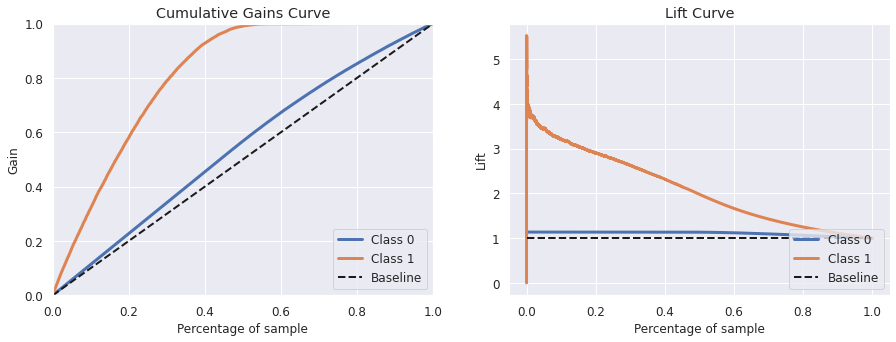

In [45]:
# Accumulative Gain
fig, axs = plt.subplots(ncols = 2, figsize = (15,5))
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb_tuned, ax = axs[0])
skplt.metrics.plot_lift_curve(y_val, yhat_xgb_tuned, ax = axs[1]);

In [ ]:
# Compute Recall at k
xgb_recall_at_20000 = round(recall_at_k(df8, x_validation, y_validation, yhat_xgb, 20000), 3)
print('XGB Model - Recall at K: {}'.format(xgb_recall_at_k))

## 10.3 Final Model x Test DataSet

### 10.3.1 Loading Test Data

In [102]:
df_train = df5.copy()

In [103]:
df_train_x = df_train.drop('response', axis = 1)
df_train_y = df_train['response'].copy()

In [104]:
df_test = pd.read_csv('/home/eron/repos/pa004_health_insurance_cross_sell/data/raw/test.csv')

In [105]:
df_test_raw = df_test.copy()

In [106]:
print ('Number of Rows: {}'.format(df_test.shape[0]))
print ('Number of Columns: {}'.format(df_test.shape[1]))

Number of Rows: 127037
Number of Columns: 11


In [107]:
df_test.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage'],
      dtype='object')

In [108]:
cols_old = df_test.columns

snakecase = lambda x: inflection.underscore (x)

cols_new = list(map(snakecase, cols_old))

df_test.columns = cols_new

In [109]:
df_test.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage'],
      dtype='object')

In [110]:
df_test['region_code'] = df_test['region_code'].astype(np.int64)
df_test['policy_sales_channel'] = df_test['policy_sales_channel'].astype(np.int64)

In [111]:
# Feature Engineering
df_test['vehicle_age'] = df_test['vehicle_age'].apply( lambda x: 3 if x == '> 2 Years' else 2 if x == '1-2 Year' else 1)
df_test['vehicle_damage'] = df_test['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0)
df_test['gender'] = df_test['gender'].apply( lambda x: 1 if x == 'Female' else 0)

damage_per_rcode = df_test[['vehicle_damage']].groupby(df_test['region_code']).mean().reset_index()
damage_per_rcode = damage_per_rcode.rename( columns = {'vehicle_damage' : 'damage_per_rcode'})
df_test = df_test.merge(damage_per_rcode, on = 'region_code', how = 'left')

In [112]:
df_test['damage_per_rcode'] = df_test['damage_per_rcode'].astype(np.float64)

In [113]:
# gender
df_test.loc[:, 'gender'] = df_test.loc[:, 'gender'].map(target_encode_gender)

# age
df_test.loc[:, 'age'] = mms_age.fit_transform(df_test[['age']].values)

# region_code - Frequency Enconding / Target Enconding / Weighted Target Enconding
df_test.loc[:, 'region_code'] = df_test.loc[:, 'region_code'].map(target_encode_region_code)

# Vehicle Age
df_test.loc[:, 'vehicle_age'] = df_test.loc[:, 'vehicle_age'].map(target_encode_vehicle_age)

# annual_premium
df_test.loc[:, 'annual_premium'] = ss.fit_transform(df_test[['annual_premium']].values)

# policy_sales_channel - Target Enconding / Frequency Enconding
df_test.loc[:, 'policy_sales_channel'] = df_test['policy_sales_channel'].map(fe_policy_sales_channel)

# vintage
df_test.loc[:, 'vintage'] = mms_vintage.fit_transform(df_test[['vintage']].values)

# fillna
df_test = df_test.fillna (0)

In [114]:
cols_selected = ['vehicle_damage', 
                 'policy_sales_channel', 
                 'vehicle_age',
                 'previously_insured',
                 'vintage',
                 'annual_premium',
                 'age',
                 'region_code',
                 'damage_per_rcode'] 

In [115]:
df_test_final    = df_test[cols_selected]
df_train_x_final = df_train_x[cols_selected]
df_train_y_final = df_train_y.copy()

In [116]:
model_xgb_tuned = xgb.XGBClassifier (objective        = xgb_param_tuned['objective'],
                                     eval_metric      = xgb_param_tuned['eval_metric'],
                                     n_estimators     = xgb_param_tuned['n_estimators'], 
                                     eta              = xgb_param_tuned['eta'], 
                                     max_depth        = xgb_param_tuned['max_depth'], 
                                     subsample        = xgb_param_tuned['subsample'],
                                     colsample_bytree = xgb_param_tuned['colsample_bytree'],
                                     min_child_weight = xgb_param_tuned['min_child_weight'])

model_xgb_tuned.fit(df_train_x_final, df_train_y_final)

yhat_xgb_tuned = model_xgb_tuned.predict_proba(df_test_final)

In [242]:
df_test_predictions = df_test_raw.copy()
df_test_predictions['score'] = yhat_xgb_tuned[:,1].tolist()
df_test_predictions = df_test_predictions.sort_values('score', ascending = False).reset_index()
df_test_predictions['ranking'] = df_test_predictions.index+1
df_test_predictions.head(5)

,index,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,score,ranking
0,101911,483021,Male,48,1,28.0,0,< 1 Year,Yes,148945.0,26.0,161,0.778307,1
1,50787,431897,Male,58,1,28.0,0,> 2 Years,Yes,107782.0,26.0,224,0.738950,2
2,120827,501937,Male,50,1,28.0,0,< 1 Year,Yes,40410.0,26.0,167,0.719469,3
3,85587,466697,Male,50,1,28.0,0,< 1 Year,Yes,38947.0,26.0,292,0.718005,4
4,113093,494203,Female,43,1,41.0,0,< 1 Year,Yes,29754.0,26.0,258,0.699315,5


## 10.3 Business Results

### 10.3.1 Business Issues

### 1. Key findings on the most relevant attributes of customers interested in purchasing car insurance.

The most relevant attributes of customers interested in purchasing motor insurance are as follows:
- **Age:** the interest in contracting car insurance is concentrated in the age range of 35 to 50 years old approximately.
- **Vehicle Damage:** almost all clients who participated in the survey and answered that they are interested in taking out auto insurance have already had damage to their vehicles.
- **Previously Insured:** almost all of the clients who expressed interest do NOT currently have insurance.
- **Vehicle Age:** the interest in contracting car insurance is concentrated on clients who own cars between 2 and 3 years old.

### 2. What percentage of customers interested in purchasing car insurance will the sales team be able to contact by making 20.000 phone calls?

### Percentage of customers interested in the first 20000 leads: 47.5%

In [156]:
calls = 20000
total_leads = df_test.shape[0]
perc_calls = calls / total_leads
print('Total leads: {}'.format(total_leads))
print('% of calls: {0:.2f}%'.format(perc_calls*100))

Total leads: 127037
% of calls: 15.74%


In [171]:
validation_dataset_leads = x_val.shape[0]
call_in_validation = validation_dataset_leads * perc_calls
print('Total validation leads: {}'.format(validation_dataset_leads))
print('number of calls: {0:.2f}'.format(call_in_validation))

Total validation leads: 76222
number of calls: 11999.97


In [191]:
# Compute Recall at k
xgb_recall_at_k = round(recall_at_k(df8, x_validation, y_validation, yhat_xgb, 12000), 3)
print('XGB Model - Recall at K: {}'.format(xgb_recall_at_k))
print('Percentage of customers interested: {}%'.format(xgb_recall_at_k*100))

XGB Model - Recall at K: 0.475
Percentage of customers interested: 47.5%


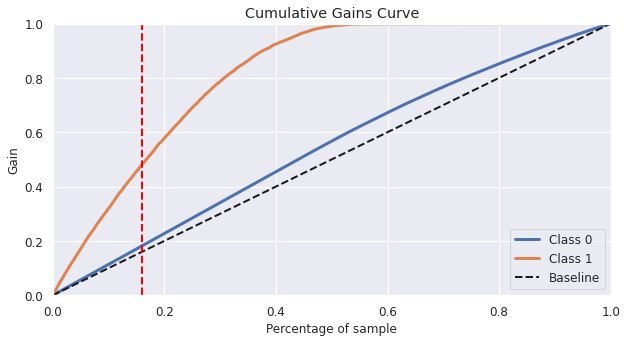

In [243]:
skplt.metrics.plot_cumulative_gain(y_validation, yhat_xgb, figsize = (10, 5))
plt.axvline(0.16, 0, 1, color = 'red', ls = '--', lw = 2);

### 3. And if the sales team's capacity increases to 40.000 phone calls, what percentage of customers interested in purchasing auto insurance will the sales team be able to contact?

### Percentage of customers interested in the first 40000 leads: 81.2%

In [172]:
calls = 40000
total_leads = df_test.shape[0]
perc_calls = calls / total_leads
print('Total leads: {}'.format(total_leads))
print('% of calls: {0:.2f}%'.format(perc_calls*100))

Total leads: 127037
% of calls: 31.49%


In [175]:
validation_dataset_leads = x_val.shape[0]
call_in_validation = validation_dataset_leads * perc_calls
print('Total validation leads: {}'.format(validation_dataset_leads))
print('Number of calls: {0:.2f}'.format(call_in_validation))

Total validation leads: 76222
Number of calls: 23999.94


In [174]:
# Compute Recall at k
xgb_recall_at_k = round(recall_at_k(df8, x_validation, y_validation, yhat_xgb, 24000), 3)
print('XGB Model - Recall at K: {}'.format(xgb_recall_at_k))
print('Percentage of customers interested: {}%'.format(xgb_recall_at_k*100))

XGB Model - Recall at K: 0.812
Percentage of customers interested: 81.2%


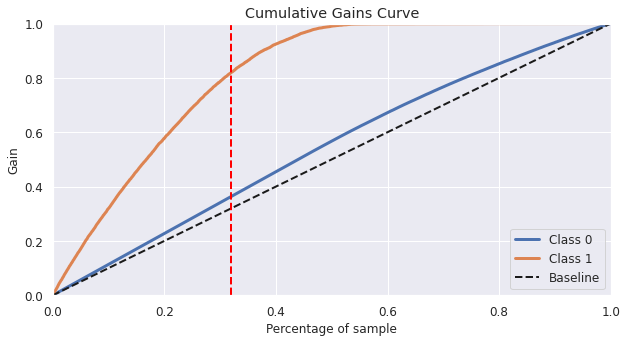

In [244]:
skplt.metrics.plot_cumulative_gain(y_validation, yhat_xgb, figsize = (10, 5))
plt.axvline(0.32, 0, 1, color = 'red', ls = '--', lw = 2);

### 4. How many phone calls do the sales team need made to contact 80% of the customers interested in purchasing car insurance?

### To contact 80% of the customers interested in purchasing car insurance, the sales team wiil be made 23442 calls.

In [233]:
df8 = x_validation.copy()
df8['response'] = y_validation.copy()
df8['score'] = yhat_xgb[:, 1].tolist()  
df8 = df8.sort_values('score', ascending = False)
df8 = df8.reset_index(drop = True)
df8['ranking'] = df8.index + 1
df8['recall_at_k'] = df8['response'].cumsum() / df8['response'].sum()
calls_at_80 = df8[df8['recall_at_k'] == 0.8]
calls_at_80.tail(1)

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_age,vehicle_damage,damage_per_rcode,response,score,ranking,recall_at_k
23441,284616,0.1039,0.092308,0.188123,0.353233,0,0.597755,0.972318,1,0.04379,1,0.66002,0,0.201921,23442,0.8


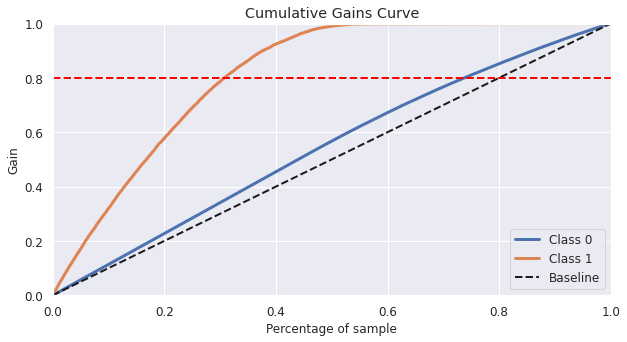

In [245]:
skplt.metrics.plot_cumulative_gain(y_validation, yhat_xgb, figsize = (10, 5))
plt.axhline(0.8, 0, 1, color = 'red', ls = '--', lw = 2);

### 4. How many phone calls do the sales team need made to contact 100% of the customers interested in purchasing car insurance?

### To contact 100% of the customers interested in purchasing car insurance, the sales team wiil be made 75963 calls or 59.80% of the DataSet.

In [234]:
df8 = x_validation.copy()
df8['response'] = y_validation.copy()
df8['score'] = yhat_xgb[:, 1].tolist()  
df8 = df8.sort_values('score', ascending = False)
df8 = df8.reset_index(drop = True)
df8['ranking'] = df8.index + 1
df8['recall_at_k'] = df8['response'].cumsum() / df8['response'].sum()
calls_at_100 = df8[df8['recall_at_k'] == 1]
calls_at_100.head(1)

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_age,vehicle_damage,damage_per_rcode,response,score,ranking,recall_at_k
75962,266276,0.13924,0.430769,0.12315,0.002207,1,-0.386571,0.979239,1,0.174348,0,0.378581,1,0.000057,75963,1.0


In [240]:
total_calls_100 = 75963
perc_of_dataset = (total_calls_100 / df_test.shape[0])*100
perc_of_dataset
print('Percentage of DataSet to contact 100% of the customers interested: {0:.2f}%'.format(perc_of_dataset))

Percentage of DataSet to contact 100% of the customers interested: 59.80%


# 11.0 Deploy to Production

In [187]:
pickle.dump( model_xgb_tuned, open( '/home/eron/repos/pa004_health_insurance_cross_sell/models/model_xgb_classifier.pkl', 'wb' ) )

## 11.1 Health Insurance Class

In [124]:
import pickle
import pandas as pd
import numpy as np
import inflection

class HealthInsurance(object):
    
    def __init__ (self):
        self.home_path             = '/home/eron/repos/pa004_health_insurance_cross_sell/'
        self.age_scaler            = pickle.load(open(self.home_path + 'src/features/age_scaler.pkl', 'rb'))
        self.annual_premium_scaler = pickle.load(open(self.home_path + 'src/features/annual_premium_scaler.pkl', 'rb'))
        self.gender_scaler         = pickle.load(open(self.home_path + 'src/features/gender_scaler.pkl', 'rb'))
        self.policy_sales_scaler   = pickle.load(open(self.home_path + 'src/features/policy_sales_scaler.pkl', 'rb'))
        self.region_code_scaler    = pickle.load(open(self.home_path + 'src/features/region_code_scaler.pkl', 'rb'))
        self.vintage_scaler        = pickle.load(open(self.home_path + 'src/features/vintage_scaler.pkl', 'rb'))
        self.vehicle_age_scaler    = pickle.load(open(self.home_path + 'src/features/vehicle_age_scaler.pkl', 'rb'))
        
    
    def data_cleaning (self, data_clean):
        # Change columns name
        cols_old = data_clean.columns
        snakecase = lambda x: inflection.underscore (x)
        cols_new = list(map(snakecase, cols_old))
        data_clean.columns = cols_new
        
        # Cheange columns type        
        data_clean['region_code'] = data_clean['region_code'].astype(np.int64)
        data_clean['policy_sales_channel'] = data_clean['policy_sales_channel'].astype(np.int64)
        
        return data_clean
    
    
    def data_engineering (self, data_eng):
        data_eng['vehicle_age'] = data_eng['vehicle_age'].apply( lambda x: 3 if x == '> 2 Years' else 2 if x == '1-2 Year' else 1)
        data_eng['vehicle_damage'] = data_eng['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0)
        data_eng['gender'] = data_eng['gender'].apply( lambda x: 1 if x == 'Female' else 0)
        damage_per_rcode = data_eng[['vehicle_damage']].groupby(data_eng['region_code']).mean().reset_index()
        damage_per_rcode = damage_per_rcode.rename( columns = {'vehicle_damage' : 'damage_per_rcode'})
        damage_per_rcode['damage_per_rcode'] = damage_per_rcode['damage_per_rcode'].astype(np.float64)
        data_eng = data_eng.merge(damage_per_rcode, on = 'region_code', how = 'left')
        
        return data_eng
        
        
    def data_preparation (self, data_prep):
        data_prep.loc[:, 'gender'] = data_prep.loc[:, 'gender'].map(self.gender_scaler)
        data_prep.loc[:, 'age'] = self.age_scaler.transform(data_prep[['age']].values)
        data_prep.loc[:, 'region_code'] = data_prep.loc[:, 'region_code'].map(self.region_code_scaler)
        data_prep.loc[:, 'vehicle_age'] = data_prep.loc[:, 'vehicle_age'].map(self.vehicle_age_scaler)
        data_prep.loc[:, 'annual_premium'] = self.annual_premium_scaler.transform(data_prep[['annual_premium']].values)
        data_prep.loc[:, 'policy_sales_channel'] = data_prep['policy_sales_channel'].map(self.policy_sales_scaler)
        data_prep.loc[:, 'vintage'] = self.vintage_scaler.transform(data_prep[['vintage']].values)
        cols_selected = ['vehicle_damage', 'policy_sales_channel', 'vehicle_age', 'previously_insured', 
                         'vintage', 'annual_premium', 'age', 'region_code', 'damage_per_rcode'] 
        
        return data_prep[cols_selected]
    
    
    def get_prediction (self, model, original_data, test_data):
        
        pred = model.predict_proba(test_data)
        original_data['score'] = pred[:,1].tolist()
        
        return original_data.to_json(orient = 'records', date_format = 'iso')

## 11.2 API Handler

In [105]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from healthinsurance.healthinsurance import HealthInsurance

#Loading Model
path = '/home/eron/repos/pa004_health_insurance_cross_sell/'
model = pickle.load(open(path + 'models/model_xgb_classifier.pkl', 'rb'))

#Initialize API
app = Flask (__name__)

@app.route('/predict', methods = ['POST'])
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json:
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index = [0])
            
        else:
            test_raw = pd.DataFrame(test_json, columns = test_json[0].keys())
        
        pipeline = HealthInsurance()
        
        data_clean = pipeline.data_cleaning(test_raw)
        
        data_eng = pipeline.data_engineering(data_clean)
        
        data_prep = pipeline.data_preparation(data_eng)
        
        data_response = pipeline.get_prediction(model, test_raw, data_prep)
        
        return data_response
    
    else:
        return Response('{}', status = 200, mimetype = 'application/json')
    
if __name__ == '__main__':
    app.run('0.0.0.0', port = 5000, debug = True)

ModuleNotFoundError: No module named 'healthinsurance'

## 11.3 API Tester

In [115]:
import requests

In [116]:
df_deploy = pd.read_csv('/home/eron/repos/pa004_health_insurance_cross_sell/data/raw/test.csv')

In [142]:
df_api_test = df_deploy.sample(10)

In [143]:
data = json.dumps(df_api_test.to_dict(orient = 'records'))

In [144]:
# url = 'http://0.0.0.0:5000/predict'
url = 'https://healthinsurance-model.herokuapp.com/predict'
header = {'Content-type' : 'application/json'}
data = data
r = requests.post(url, data = data, headers = header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [145]:
df_result = pd.DataFrame( r.json(), columns = r.json()[0].keys() )
df_result.sort_values( 'score', ascending = False ).head(10)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,score
8,398364,1,43,1,28,0,2,1,47506.0,26,262,0.791632
2,493488,0,46,1,28,0,2,1,51251.0,30,208,0.704883
3,467374,1,56,1,28,0,2,1,35453.0,124,287,0.550020
0,468742,0,57,1,18,0,2,1,32937.0,124,268,0.549392
1,401582,1,57,1,8,0,2,1,34862.0,7,279,0.465016
4,507687,0,58,1,3,0,2,1,2630.0,124,170,0.447572
6,400147,0,29,1,39,1,2,1,2630.0,156,89,0.005419
7,453330,0,30,1,35,1,1,0,35546.0,152,93,0.000455
9,393683,1,23,1,28,1,1,0,40986.0,152,61,0.000409
5,419788,0,22,1,47,1,1,0,26689.0,152,228,0.000234
